# Assessment for Advanced Data Science
# *Data Pipelines*

## Radzim Sendyka, Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 19 November 2024

Welcome to the course assessment for the Advanced Data Science unit. In this assessment, you will build two data pipelines and prediction systems.

The maximum total mark for this assessment is 20. That mark is split into two miniprojects below.
- The first miniproject is worth 7 marks.
- The second miniproject is worth 13 marks.

*The check Session for this Assessment is 03 December 2024.*

# Task 1 (7 marks)

This example project builds on your experience from the practicals, using Open Street Maps, and connecting them to real-world datasets.

Your prediction system will be based on data from the 2021 UK Census, and Open Street Maps.

### Build a data pipeline and prediction system

Structure your system around the [Access-Assess-Address](https://inverseprobability.com/talks/notes/access-assess-address-a-pipeline-for-automated-data-science.html) framework for automated data science.
Use the framework of [Data Readiness Levels](https://inverseprobability.com/publications/data-readiness-levels.html) to track the state of your datasets throughout the process.
Visualise your data and predictions using appropriate charts and graphics.
Remember, your notebook should tell a story.

1.1. Download the data from online sources. In this task you will need:
  - UK Census Data
    - The UK Census data file for and Socio-economic Classification (NS SEC) [here](https://www.ons.gov.uk/datasets/TS062/editions/2021/versions/5) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk). Use the most detailed area type (Output Areas).
    - One other UK Census data file of your choosing [here](https://www.ons.gov.uk/search?topics=9731,6646,3845,9497,4262,4128,7755,4994,6885,9724,7367&filter=datasets) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk). Use the most detailed area type available.
    - Geographic coordinates of Census Output Areas [here](https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2).
  - Spatial data
    - Set up an API connection to Open Street Maps [here](https://osmnx.readthedocs.io/en/stable/). Optionally, to be able to use more data in training, you might want to also download the entire map for England (or more) [here](https://download.openstreetmap.fr/extracts/) or [here](https://wiki.openstreetmap.org/wiki/Planet.osm).

1.2. Structure the data, and upload it to your AWS database.

- Census datasets can be huge and unwieldy to manipulate directly in python frameworks such as pandas. As a result we will host the data in a relational database.

- Using a cloud hosted database (such as MariaDB hosted on the AWS RDS service),  you will construct a database containing tables that contain per-output-area data, latitudes and longitudes of the output areas, and potentially, extracted selected open street maps features from the country-wide data file.

- Make sure you set the correct indices on your data, which will allow your code to run much faster. Hint: create an index on any columns you will be looking up, and joint indices if your lookup involves multiple columns (like coordinates).

You will likely find the following resources helpful.

- Lecture 1, 2 and 3.
- Lab class 1 and 2.


- *Note, this particular dataset could probably be handled directly in pandas, but you are explicitly tasked with using a database. This is a compromise from previous iterations of this course, where students spent quite a lot of time struggling from the size of the data. This is an opportunity for you to demonstrate your skills, as well as prepare for the second part of the assessment where databases might be necessary. Approach that do not use databases where needed will be penalised during marking.*


2.0. Explore the data.

  - To make predictions you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will need to use the techniques you have learnt in the course to indentify and incorporate useful features for your prediction tasks.
  - Look at the percentage of students (NS SEC code L15) in the individual output areas, and explore how it's related to various types of open street map features in those locations. Use the relationships you found to suggest the features to be used in a system that predicts percentage of students in a given area.
  - Do the same for an additional census variable (e.g., the average age in a given area).

3.0. Make a prediction system.
- Use Open Street Maps to predict Socio-Economic Status - in particular, the percent of full time students, from OSM features. Your function should take as input a coordinate pair (you can assume it will be in England), and return an estimate for the share of students in that area.

- Do the same for the additional census variable you selected in the previous step.

Hints:

  - *Some of the census data sheets are very detailed. You might want to try "boiling them down" to some aggregate value or selecting just the most important columns.*

  - *This assignment is focused on data pipelines, rather than machine learning, so we do not expect any advanced architectures here - a linear model or similar is perfectly fine.*
  
  - *For data exploration, or picking your second dataset, you may find useful the [interactive map](https://www.ons.gov.uk/census/maps/) of the census data.*

### Story

- Remember the notebook you create should tell a story, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template). Make sure your decisions are well substanciated and flow nicely throughout the notebook, with clear explanations.

- Explain everything you do. Why is your question important, why you selected the datasets you did, why did you join them how you did, why did you look at the things you looked at.

Make sure in your notebook you discuss the design decisions you made in your pipeline and prediction system. How did you structure your notebook? How did you track data readiness? Which aspects of your system could be improved further?

Make sure you compare how you predict student population and your second chosen property. What differences are there, in the underlying data, process, and results?

Make sure you discuss the reusability of your data pipeline and prediction system. What changes to the underlying data/system is it resilient to, and what isn't it? What work would need to be done to adjust it to answer questions about other statistics, or a different country, instead?

### Fynesse library

- Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (https://github.com/lawrennd/fynesse_template) for structuring your code.

- One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.
You should base your module on the template repository given by the Fynesse template repository. That should make it pip-installable as below.
`%pip install git+https://github.com/lawrennd/fynesse_template.git`. You can either replace fynesse with the name you've given your analysis module or you can leave the name as fynesse if you prefer.

- Remember the notebook you create should tell a story, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template). Remember to include you fynesse library in your submission.

## Installs and imports

In [619]:
import subprocess
import glob
import warnings
import os
import csv
import zipfile
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyproj import Proj, transform
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

Let's start with installing, importing, and checking contents of fynesse library:

In [ ]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

In [554]:
import fynesse

## Access

We will download needed data from online sources and upload it to the database. Datasets that we are going to use can be huge and unwieldy to manipulate directly in python frameworks such as pandas. Therefore, we will host the data in a cloud hosted relational database (such as MariaDB hosted on the AWS RDS service).

Now let's structure the data and upload it to our AWS database.

We will construct tables that contain per-output-area data, latitudes and longitudes of the output areas, (and potentially, extracted selected open street maps features from the country-wide data file).

In [1494]:
conn = fynesse.access.create_connection()

Connection established!


### Census Data

- UK Census data file for and Socio-economic Classification (NS SEC) - we will use the most detailed area type (Output Areas).
- One other UK Census data file of our choosing - we will use Migrant Indicator - we will use the most detailed area type (Output Areas).
- Geographic coordinates of Census Output Areas - two types.

In [ ]:
fynesse.access.download_census_data('TS062')

fynesse.access.download_census_data('TS019')

fynesse.access.download_data_csv(['https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/6beafcfd9b9c4c9993a06b6b199d7e6d/csv?layers=0'], ['uk_oa_list.csv'])

url = "https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/6beafcfd9b9c4c9993a06b6b199d7e6d/shapefile?layers=0"
zip_file_path = "uk_oa_with_borders.zip"
extraction_folder = "uk_oa_with_borders"
fynesse.access.download_and_extract_zip(url, zip_file_path, extraction_folder)
gdf_oa_boundaries_2021 = gpd.read_file('uk_oa_with_borders/OA_2021_EW_BGC_V2.shp')
fynesse.access.df_to_csv(gdf_oa_boundaries_2021, "uk_oa_with_boundaries.csv")

In [280]:
query_create_data_oa = """
CREATE TABLE IF NOT EXISTS `data_oa` (
  `FID` int unsigned NOT NULL,
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `ShapeArea` float NOT NULL,
  `ShapeLength` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_data_oa)

fynesse.access.csv_to_db(conn, 'uk_oa_list.csv', 'data_oa', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_oa', 'data_oa', 'OA21CD')

query_create_data_oa_with_boundaries = """
CREATE TABLE IF NOT EXISTS `data_oa_with_boundaries` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `Geometry` text COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_data_oa_with_boundaries)

fynesse.access.csv_to_db(conn, 'uk_oa_with_boundaries.csv', 'data_oa_with_boundaries', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_oa', 'data_oa_with_boundaries', 'OA21CD')

query_create_oa_data = """
CREATE TABLE oa_data AS
SELECT 
    data_oa.*,
    data_oa_with_boundaries.geometry AS geometry_string_ne
FROM 
    data_oa 
    JOIN data_oa_with_boundaries 
    ON data_oa.OA21CD = data_oa_with_boundaries.OA21CD;
"""

fynesse.assess.execute_query(conn, query_create_oa_data)

fynesse.assess.execute_query(conn, "ALTER TABLE oa_data ADD PRIMARY KEY (FID);")

fynesse.assess.execute_query(conn, "DROP TABLE data_oa;")
fynesse.assess.execute_query(conn, "DROP TABLE data_oa_with_boundaries;")

Loading data into the table
Data loaded into the table data_oa
Loading data into the table
Data loaded into the table data_oa_with_boundaries


[]

In [ ]:
query_create_census_data_nssec = """
CREATE TABLE IF NOT EXISTS `census_data_nssec` (
  `date` int unsigned NOT NULL,
  `geography` varchar(9) COLLATE utf8_bin NOT NULL,
  `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
  `NSSEC_Total` int unsigned,
  `NSSEC_L1_L2_L3` int unsigned,
  `NSSEC_L4_L5_L6` int unsigned,
  `NSSEC_L7` int unsigned,
  `NSSEC_L8_L9` int unsigned,
  `NSSEC_L10_L11` int unsigned,
  `NSSEC_L12` int unsigned,
  `NSSEC_L13` int unsigned,
  `NSSEC_L14` int unsigned,
  `NSSEC_L15` int unsigned,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_census_data_nssec)

fynesse.access.csv_to_db(conn, 'census2021-ts062/census2021-ts062-oa.csv', 'census_data_nssec', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_geography', 'census_data_nssec', 'geography')

query_create_census_data_mi = """
CREATE TABLE IF NOT EXISTS `census_data_mi` (
  `date` int unsigned NOT NULL,
  `geography` varchar(9) COLLATE utf8_bin NOT NULL,
  `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
  `MI_Total` int unsigned,
  `MI_AddrYearAgoSameInUK` int unsigned,
  `MI_AddrYearAgoStudentInUK` int unsigned,
  `MI_AddrYearAgoInUK` int unsigned,
  `MI_AddrYearAgoOutUK` int unsigned,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_census_data_mi)

fynesse.access.csv_to_db(conn, 'census2021-ts019/census2021-ts019-oa.csv', 'census_data_mi', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_geography', 'census_data_mi', 'geography')

query_create_census_data_1 = """
CREATE TABLE census_data_1 AS
SELECT 
    census_data_nssec.*, 
    census_data_mi.MI_Total, 
    census_data_mi.MI_AddrYearAgoSameInUK, 
    census_data_mi.MI_AddrYearAgoStudentInUK, 
    census_data_mi.MI_AddrYearAgoInUK, 
    census_data_mi.MI_AddrYearAgoOutUK 
FROM 
    census_data_nssec 
    JOIN census_data_mi 
    ON census_data_nssec.geography = census_data_mi.geography;
"""

fynesse.assess.execute_query(conn, query_create_census_data_1)

fynesse.assess.execute_query(conn, "DROP TABLE census_data_nssec;")

fynesse.assess.execute_query(conn, "DROP TABLE census_data_mi;")

### Spatial data

We will also need to get spatial data - we will get it using Open Street Maps.

In [33]:
features_df = [
 'geometry',
 'ways',
 'nodes',
 'type',
 'addr:country',
 'addr:postcode',
 'addr:street',
 'addr:housenumber',
 'addr:city',
 'addr:housename',
 'addr:place',

 'name',
 'alt_name',
 'old_name',
 'nohousenumber',
 'note',

 'disused',
 'height',

 'amenity',
 'tourism',
 'brand',
 'leisure',
 'cuisine',
 'emergency',
 'historic',
 'sport',
 'shop',
 'religion',
 'power',
 'military',

 'house',
 'building',
 'building:material',
 'building:levels',
 'internet_access',

 'capacity',
 'roof:levels',
 'roof:shape'
 'fee',
 'man_made',
 'denomination',
 'layer']

features_db = ['element_type', 'osmid'] + features_df

In [ ]:
ew_bounds = {"north": 55.8, "south": 49.8, "east": 2.0, "west": -7.0}

west = -7.0
south = 49.8
step = 0.5
tags = {"building": True}

for i in range(5, 12):
    for j in range(0, 18):
        if i == 3 and (j == 13 or j == 14):
            continue # Greater London has to be processed separately
        file_name = f'osm_uk_{i}_{j}.csv'
        print(f'Getting dataframe to form {file_name}')
        bounds = (south + step * (i + 1), south + step * i, west + step * (j + 1), west + step * j)
        try:
            df = fynesse.access.get_all_buildings_from_osm_by_bounds(bounds, tags)
            for feature in features_df:
                if feature not in df.columns:
                    df[feature] = None
            df = df[features_df]
            df.to_csv("./" + file_name, index=True, header=True)
            print(f'{file_name} has been formed successfully')
        except Exception as e:
            print(f'{file_name} has not been created due to error "{e}"')

In [ ]:
gl_bounds = {"north": 51.8, "south": 51.3, "east": 0.5, "west": -0.5}

west = -0.5
south = 51.3
step = 0.25
tags = {"building": True}

for i in range(0, 2):
    for j in range(0, 4):
        file_name = f'osm_uk_gl_{i}_{j}.csv'
        print(f'Getting dataframe to form {file_name}')
        bounds = (south + step * (i + 1), south + step * i, west + step * (j + 1), west + step * j)
        try:
            df = fynesse.access.get_all_buildings_from_osm_by_bounds(bounds, tags)
            for feature in features_df:
                if feature not in df.columns:
                    df[feature] = None
            df = df[features_df]
            df.to_csv("./" + file_name, index=True, header=True)
            print(f'{file_name} has been formed successfully')
        except Exception as e:
            print(f'{file_name} has not been created due to error "{e}"')

Let's check row count in uploaded files:

In [1258]:
file_pattern = "used_osm_uk_data/osm_uk_*.csv"
file_list = glob.glob(file_pattern)
file_list.sort()

rows = 0

for file_name in file_list:
    try:
        result = subprocess.run(['wc', '-l', file_name], capture_output=True, text=True)
        row_count = int(result.stdout.split()[0]) - 1
        rows += row_count
    except Exception as e:
        print(f'Error processing {file_name}: {e}')

print(f'Files {file_pattern} have {rows} rows in total')

Files used_osm_uk_data/osm_uk_*.csv has 15453992 rows in total


Let's apply basic filter to OSM data - we are going to select only data with valid postcode. While this is not absolutely necessary, it might simplify operations in the future, and it also helps to decrease the size of the dataset.

In [ ]:
file_pattern = "used_osm_uk_data/osm_uk_*.csv"
file_list = glob.glob(file_pattern)
file_list.sort()

total_rows_with_postcode = 0
output_file = "osm_uk_valid_data.csv"
header = True

for file_name in file_list:
    df = pd.read_csv(file_name)
    df_with_postcode = df[(df[["addr:postcode"]].notnull().any(axis=1))]
    total_rows_with_postcode += len(df_with_postcode)
    df_with_postcode.to_csv(output_file, mode ='a', index=False, header=header)
    header = False
    print(file_name + " has been processed.")

print("Rows with 'postcode' field not empty:", total_rows_with_postcode)

We ended up with 2.5M rows.

In [1259]:
file_name = "osm_uk_valid_data.csv"
result = subprocess.run(['wc', '-l', file_name], capture_output=True, text=True)
row_count = int(result.stdout.split()[0]) - 1
print(f'File {file_name} has {row_count} rows')

File osm_uk_valid_data.csv has 2546212 rows


In [1492]:
features_db = [feature.replace(":", "_") for feature in features_db]

query_create_osm_data_temp = """
CREATE TABLE IF NOT EXISTS `osm_data_temp` (
"""

rows = [f'  `{features_db[i]}` text COLLATE utf8_bin NOT NULL,\n' for i in range(len(features_db))]
rows[1] = f'  `{features_db[1]}` int unsigned NOT NULL,\n'
rows[2] = f'  `geometry_string` text COLLATE utf8_bin NOT NULL,\n'
for row in rows:
  query_create_osm_data_temp += row

query_create_osm_data_temp += """  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_osm_data_temp)

fynesse.access.csv_to_db(conn, 'osm_uk_valid_data.csv', 'osm_data', ignore_first_row=True)

Loading data into the table
Data loaded into the table osm_data_temp


In [289]:
fynesse.assess.execute_query(conn, "ALTER TABLE osm_data RENAME COLUMN geometry_string TO geometry_string_ll;")

[]

### Indexing data

We have to make sure that we set the correct indices on our data, as this will allow our code to run much faster. The best way to do that is to create an index on any column we will be looking up, and joint indices if our lookup involves multiple columns (like coordinates).

In [1336]:
fynesse.assess.create_single_index(conn, 'idx_geography', 'census_data_1', 'geography')
fynesse.assess.create_single_index(conn, 'idx_geography_code', 'census_data_1', 'geography_code')

[]

In [292]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'oa_data', 'OA21CD')
fynesse.assess.create_single_index(conn, 'idx_lsoa', 'oa_data', 'LSOA21CD')
fynesse.assess.create_multiple_index(conn, 'idx_lat_lon_btree', 'oa_data', ['LAT', 'LON'])

[]

In [412]:
fynesse.assess.create_single_index(conn, 'idx_postcode', 'osm_data', 'addr_postcode')

[]

As it's not always possible to predict which columns have to be indexed, we might return to this later in the project. This is an example of the situation when we have to alternate between the parts of our fynesse framework in order to run our project smoothly.

### Summary on access

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))')
Indices:
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON

Table osm_data - Approx Row Count 2.5M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1)
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2)
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3)
Indices:
 - idx_postcode (BTREE): Column addr_postcode

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

## Assess

In [512]:
conn = fynesse.access.create_connection()

Connection established!


### Creating osm_data_sample

OSM data has 2.5M entries, so let's create a small (1K rows) subset of it representing all three types of elements.

In [296]:
query = """
CREATE TABLE osm_data_sample AS
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'relation' LIMIT 100
) AS relation_sample
UNION ALL
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'node' LIMIT 100
) AS node_sample
UNION ALL
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'way' LIMIT 800
) AS way_sample;
"""
fynesse.assess.execute_query(conn, query)

[]

### Transforming osm_data geometries to National Grid format

In [303]:
from shapely import wkt
import geopandas as gpd
from pyproj import CRS

In [321]:
fynesse.access.db_to_csv(conn, 'osm_data', 'backup/osm_data.csv')
df = pd.read_csv('backup/osm_data.csv')

Data successfully exported to backup/osm_data.csv


/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8285/3719149625.py:2: DtypeWarning: Columns (3,5,11,12,14,15,16,17,18,19,21,23,25,26,27,30,31,32,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('backup/osm_data.csv')


In [322]:
df = df[['db_id', 'geometry_string_ll']]
df['geometry'] = df['geometry_string_ll'].apply(wkt.loads)  # converting WKT strings to geometries
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # setting CRS to WGS84 (EPSG:4326)

# Define the CRS for the transformation
wgs84 = CRS.from_epsg(4326)
osgb = CRS.from_epsg(27700)

# Transform geometries
gdf = gdf.set_crs(wgs84, allow_override=True)  # Set input CRS to WGS84
gdf = gdf.to_crs(osgb)  # Reproject to OSGB
gdf = gdf[['db_id', 'geometry']]

fynesse.access.df_to_csv(gdf, 'backup/geometry_temp.csv')

DataFrame successfully saved to backup/geometry_temp.csv


In [323]:
query_create_geometry_temp = """
CREATE TABLE IF NOT EXISTS `geometry_temp` (
  `db_id` bigint(20) unsigned NOT NULL,
  `geometry_string_ne` text COLLATE utf8_bin NOT NULL,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_geometry_temp)

fynesse.access.csv_to_db(conn, 'backup/geometry_temp.csv', 'geometry_temp', True)

Loading data into the table
Data loaded into the table geometry_temp


In [324]:
query = """
ALTER TABLE osm_data
ADD COLUMN geometry_string_ne text;
"""
fynesse.assess.execute_query(conn, query)

[]

In [325]:
query = """
UPDATE osm_data
JOIN geometry_temp ON osm_data.db_id = geometry_temp.db_id
SET osm_data.geometry_string_ne = geometry_temp.geometry_string_ne;
"""
fynesse.assess.execute_query(conn, query)

[]

In [326]:
fynesse.assess.execute_query(conn, "DROP TABLE geometry_temp;")

[]

### Transforming osm_data geometries to binary

In [380]:
query = """
ALTER TABLE osm_data
ADD COLUMN geometry geometry;
"""
fynesse.assess.execute_query(conn, query)

[]

In [381]:
query = """
UPDATE osm_data
SET geometry = ST_GeomFromText(geometry_string_ne);
"""
fynesse.assess.execute_query(conn, query)

[]

In [385]:
fynesse.assess.execute_query(conn, "SELECT COUNT(*) FROM osm_data WHERE geometry IS NULL;")

((0,),)

In [404]:
fynesse.assess.execute_query(conn, "ALTER TABLE osm_data MODIFY COLUMN geometry GEOMETRY NOT NULL;")

[]

In [405]:
fynesse.assess.execute_query(conn, "ALTER TABLE osm_data ADD SPATIAL INDEX (geometry);")

[]

### Transforming oa_data geometries to binary

In [319]:
query = """
ALTER TABLE oa_data
ADD COLUMN geometry geometry;
"""
fynesse.assess.execute_query(conn, query)

[]

In [320]:
query = """
UPDATE oa_data
SET geometry = ST_GeomFromText(geometry_string_ne);
"""
fynesse.assess.execute_query(conn, query)

[]

In [394]:
fynesse.assess.execute_query(conn, "SELECT COUNT(*) FROM oa_data WHERE geometry IS NULL;")

((1,),)

In [395]:
fynesse.assess.execute_query(conn, "SELECT db_id, geometry_string_ne FROM oa_data WHERE geometry IS NULL;")

((128262,
  'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.1899999995, 583697.4400000004 344225.19999999925, 583696.96 344201.4299999997, 583719.3600000003 344177.6199999992)), ((583727.1950000003 344200.9389999993, 583766.6399999997 344180.8629999999, 583721

In [397]:
fynesse.assess.execute_query(conn, "DELETE FROM oa_data WHERE db_id = 128262;")
fynesse.assess.execute_query(conn, "SELECT * FROM oa_data WHERE db_id = 128262;")

()

In [481]:
# geography_code = 'E00135410'

In [480]:
fynesse.assess.execute_query(conn, "DELETE FROM census_data_1 WHERE db_id = 128262;")
fynesse.assess.execute_query(conn, "SELECT * FROM census_data_1 WHERE db_id = 128262;")

()

In [401]:
fynesse.assess.execute_query(conn, "ALTER TABLE oa_data MODIFY COLUMN geometry GEOMETRY NOT NULL;")

[]

In [403]:
fynesse.assess.execute_query(conn, "ALTER TABLE oa_data ADD SPATIAL INDEX (geometry);")

[]

### Intermediate summary

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@")
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

### Assigning OSM objects to their Output Areas

In [421]:
query = """
ALTER TABLE osm_data_sample
ADD COLUMN OA21CD varchar(9);
"""
fynesse.assess.execute_query(conn, query)

[]

In [423]:
query = """
UPDATE osm_data_sample
JOIN oa_data
ON ST_Contains(oa_data.geometry, osm_data_sample.geometry)
SET osm_data_sample.OA21CD = oa_data.OA21CD;
"""
fynesse.assess.execute_query(conn, query)

[]

In [425]:
fynesse.assess.execute_query(conn, "SELECT MIN(db_id) AS min_db_id, MAX(db_id) AS max_db_id FROM osm_data;")

((1, 2546167),)

In [427]:
query = """
ALTER TABLE osm_data
ADD COLUMN OA21CD varchar(9);
"""
fynesse.assess.execute_query(conn, query)

[]

The following takes about 20-30s per loop to run:

In [ ]:
for i in range(0, 260):

    a = i * 10000
    b = (i + 1) * 10000

    query = f"""
    UPDATE osm_data
    JOIN oa_data
    ON ST_Contains(oa_data.geometry, osm_data.geometry)
    SET osm_data.OA21CD = oa_data.OA21CD
    WHERE osm_data.db_id >= {a} AND osm_data.db_id < {b};
    """
    fynesse.assess.execute_query(conn, query)

    # print(f"Batch with db_id in the range [{a}, {b}) has been processed.")

In [449]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'osm_data', 'OA21CD')

[]

In [453]:
fynesse.assess.execute_query(conn, "SELECT COUNT(*) FROM osm_data;")

((2546167,),)

In [454]:
fynesse.assess.execute_query(conn, "SELECT COUNT(*) FROM osm_data WHERE OA21CD IS NULL;")

((158823,),)

Out of 2546167 objects stored in osm_data 158823 weren't identified with any output area, hence 2387344 osm_data objects have valid OA21CD - this is 93.76% of the total number of osm_data objects.

### UNUSED - Assigning OSM objects to their Output Areas using dataframes

Unfortunately, it's not always possible to conduct geometrical operation in databases. Our next subtask will be to figure out the code of the Output Area to which each of 2.5M OSM data objects belong. Due to limited time we will have to switch to dataframes in order to speed up this process.

In [1759]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

In [1762]:
fynesse.access.db_to_csv(conn, 'oa_data', 'backup/oa_data.csv')
fynesse.access.db_to_csv(conn, 'osm_data', 'backup/osm_data.csv')

oa_data_df = pd.read_csv('backup/oa_data.csv')
osm_data_df = pd.read_csv('backup/osm_data.csv')

oa_data_df = oa_data_df[['OA21CD', 'geometry_string']]
osm_data_df = osm_data_df[['db_id', 'geometry_string']]

"""
oa_data_df['geometry'] = oa_data_df['geometry_string'].apply(wkt.loads)  # converting WKT strings to geometries
oa_data_gdf = gpd.GeoDataFrame(oa_data_df, geometry='geometry')  # converting DataFrame to GeoDataFrame
oa_data_gdf.set_crs("EPSG:27700", inplace=True)  # setting CRS to EPSG:27700 (UK Grid)

osm_data_df['geometry'] = osm_data_df['geometry_string'].apply(wkt.loads)  # converting WKT strings to geometries
osm_data_gdf = gpd.GeoDataFrame(osm_data_df, geometry='geometry', crs="EPSG:4326")  # setting CRS to WGS84 (EPSG:4326)
osm_data_gdf = osm_data_gdf.to_crs(oa_data_gdf.crs)
"""

oa_data_df['geometry'] = oa_data_df['geometry_string_ne'].apply(wkt.loads)  # converting WKT strings to geometries
oa_data_gdf = gpd.GeoDataFrame(oa_data_df, geometry='geometry')  # converting DataFrame to GeoDataFrame
oa_data_gdf.set_crs("EPSG:27700", inplace=True)  # setting CRS to EPSG:27700 (UK Grid)

osm_data_df['geometry'] = osm_data_df['geometry_string_ne'].apply(wkt.loads)  # converting WKT strings to geometries
osm_data_gdf = gpd.GeoDataFrame(osm_data_df, geometry='geometry')  # converting DataFrame to GeoDataFrame
osm_data_gdf.set_crs("EPSG:27700", inplace=True)  # setting CRS to EPSG:27700 (UK Grid)

result = gpd.sjoin(osm_data_gdf, oa_data_gdf[['OA21CD', 'geometry']], how='left', predicate='within') # spatial join
result_df = result[['db_id', 'OA21CD']]

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_33730/754419987.py:2: DtypeWarning: Columns (3,5,11,12,14,15,16,17,18,19,21,23,25,26,27,30,31,32,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_data_df = pd.read_csv('backup/osm_data.csv')


In [1767]:
result_df = result_df.dropna(subset=['OA21CD'])

In [1770]:
fynesse.access.df_to_csv(result_df, 'backup/sjoin_results.csv')

DataFrame successfully saved to backup/sjoin_results.csv


In [1773]:
query_create_sjoin_results = """
CREATE TABLE IF NOT EXISTS `sjoin_results` (
  `db_id` bigint(20) unsigned NOT NULL,
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_sjoin_results)

fynesse.access.csv_to_db(conn, 'sjoin_results.csv', 'sjoin_results', True)

Loading data into the table
Data loaded into the table sjoin_results


In [1777]:
fynesse.assess.create_single_index(conn, 'idx_db_id', 'osm_data', 'db_id')

[]

In [1791]:
query = """
ALTER TABLE osm_data
ADD COLUMN OA21CD VARCHAR(9) DEFAULT NULL;
"""
fynesse.assess.execute_query(conn, query)

[]

In [1792]:
query = """
UPDATE osm_data
JOIN sjoin_results ON osm_data.db_id = sjoin_results.db_id
SET osm_data.OA21CD = sjoin_results.OA21CD;
"""
fynesse.assess.execute_query(conn, query)

[]

In [112]:
fynesse.assess.execute_query(conn, "DROP TABLE sjoin_results;")

[]

### Adding OSM information

Let's augment our data with information obtained from Open Street Map to indentify and incorporate useful features for our prediction tasks.

Selecting features of interest from the list of available features and counting number of instances of each of them in each Output Area.

In [456]:
features_of_interest = ['amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building']

In [462]:
for feature in features_of_interest:
    
    print(f"Feature {feature} is being processed...")
    
    query = f"""
    ALTER TABLE census_data_1
    ADD COLUMN {feature} INT DEFAULT 0;
    """
    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    LEFT JOIN (
        SELECT 
            OA21CD, 
            COUNT(*) AS non_empty_{feature}_count
        FROM 
            osm_data
        WHERE 
            OA21CD IS NOT NULL AND {feature} IS NOT NULL AND {feature} != ''
        GROUP BY 
            OA21CD
    ) AS grouped_counts
    ON census_data_1.geography_code = grouped_counts.OA21CD
    SET census_data_1.{feature} = COALESCE(grouped_counts.non_empty_{feature}_count, 0);
    """
    fynesse.assess.execute_query(conn, query)

    print(f"Feature {feature} has been processed.")

Feature amenity is being processed...
Feature amenity has been processed.
Feature tourism is being processed...
Feature tourism has been processed.
Feature leisure is being processed...
Feature leisure has been processed.
Feature cuisine is being processed...
Feature cuisine has been processed.
Feature emergency is being processed...
Feature emergency has been processed.
Feature historic is being processed...
Feature historic has been processed.
Feature sport is being processed...
Feature sport has been processed.
Feature shop is being processed...
Feature shop has been processed.
Feature religion is being processed...
Feature religion has been processed.
Feature power is being processed...
Feature power has been processed.
Feature military is being processed...
Feature military has been processed.
Feature house is being processed...
Feature house has been processed.
Feature building is being processed...
Feature building has been processed.


### UNUSED - Adding OSM information with dataframes

In [689]:
# not optimal with dataframes

"""
for feature in features_of_interest:
    oa_data_gdf[feature] = oa_data_gdf.apply(lambda row: len(osm_data_gdf[(osm_data_gdf['OA21CD'] == row['OA21CD']) & (osm_data_gdf[feature] != '') & (osm_data_gdf[feature].notna())]), axis=1)
"""

In [1410]:
# with dataframes

"""
grouped_counts = {feature: osm_data_gdf[(osm_data_gdf[feature].notna()) & (osm_data_gdf[feature] != '')].groupby('OA21CD').size() for feature in features_of_interest}

for feature in features_of_interest:
    oa_data_gdf[feature] = oa_data_gdf['OA21CD'].map(grouped_counts[feature]).fillna(0).astype(int)
"""

### Adding advanced OSM metrics

In [ ]:
features_of_interest_nearby = [feature + '_nearby' for feature in features_of_interest]

In [ ]:
for feature in features_of_interest:

    query = f"""
    ALTER TABLE census_data_1 
    ADD COLUMN {feature}_nearby INT DEFAULT 0;
    """
    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    LEFT JOIN (
        SELECT 
            oa_data.OA21CD, 
            COUNT(*) AS nearby_{feature}_count
        FROM 
            oa_data
        JOIN 
            osm_data
        ON 
            ST_Distance_Sphere(oa_data.geometry, osm_data.geometry) <= 1000
        WHERE 
            osm_data.{feature} IS NOT NULL AND osm_data.{feature} != ''
        GROUP BY 
            oa_data.OA21CD
    ) AS grouped_counts
    ON census_data_1.geography_code = grouped_counts.OA21CD
    SET census_data_1.{feature}_nearby = COALESCE(grouped_counts.nearby_{feature}_count, 0);
    """
    fynesse.assess.execute_query(conn, query)
    
    print(f"Feature {feature} has been processed.")


### UNUSED - Adding advanced OSM metrics with dataframes

It makes more sense to include all objects located in proximity to given Output Area.

Please be aware that this operation is almost undoable in MariaDB database and will be done with the help of dataframes due to the following main factors:
 - lack of support for advanced spatial operations in MariaDB;
 - this type of operation requires very huge amount of time;
 - MariaDb lacks support for optimal ways of doing this, while performance speed with dataframes is very good (about 1 minute per feature);
 - last point might make dataframes preferable even when dealing with very large amounts of data (we will only need to split data into patches);
 - fortunately, this isn't our concern in this case.

In [97]:
features_of_interest_nearby = [feature + '_nearby' for feature in features_of_interest]

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

In [1818]:
fynesse.access.db_to_csv(conn, 'oa_data', 'backup/oa_data.csv')
fynesse.access.db_to_csv(conn, 'osm_data', 'backup/osm_data.csv')

Data successfully exported to backup/oa_data.csv
Data successfully exported to backup/osm_data.csv


In [ ]:
oa_data_df = pd.read_csv('backup/oa_data.csv')
oa_data_df = oa_data_df[['OA21CD', 'geometry_string']]
oa_data_df['geometry'] = oa_data_df['geometry_string'].apply(wkt.loads)  # Convert WKT to geometries
oa_data_gdf = gpd.GeoDataFrame(oa_data_df, geometry='geometry')  # Create GeoDataFrame
oa_data_gdf.set_crs("EPSG:27700", inplace=True)  # Set CRS to EPSG:27700 (UK Grid)

In [11]:
osm_data_df = pd.read_csv('backup/osm_data.csv')
osm_data_df = osm_data_df[['db_id', 'geometry_string', 'OA21CD'] + features_of_interest]
osm_data_df['geometry'] = osm_data_df['geometry_string'].apply(wkt.loads)  # Convert WKT to geometries
osm_data_gdf = gpd.GeoDataFrame(osm_data_df, geometry='geometry', crs="EPSG:4326")  # Set CRS to WGS84 (EPSG:4326)
osm_data_gdf = osm_data_gdf.to_crs(oa_data_gdf.crs)  # Reproject osm_data to match oa_data CRS

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8285/3572026491.py:1: DtypeWarning: Columns (3,5,11,12,14,15,16,17,18,19,21,23,25,26,27,30,31,32,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_data_df = pd.read_csv('backup/osm_data.csv')


In [31]:
results_df = pd.DataFrame({'OA21CD': oa_data_gdf['OA21CD']})
results_df.set_index('OA21CD', inplace=True)

In [15]:
oa_data_gdf['buffer'] = oa_data_gdf.geometry.buffer(1000)  # Buffer distance in meters (EPSG:27700 is metric) - create a 1km buffer around each output area
oa_data_gdf.set_geometry('buffer', inplace=True)

In [75]:
for feature in features_of_interest:
    
    print(f"Feature {feature} is being processed...")

    osm_data_gdf_feature = osm_data_gdf.copy()[['geometry', feature, 'OA21CD']]
    osm_data_gdf_feature = osm_data_gdf_feature[osm_data_gdf_feature[feature].notna() & (osm_data_gdf_feature[feature] != '')]
    osm_data_gdf_feature.set_geometry('geometry', inplace=True)

    joined = gpd.sjoin(osm_data_gdf_feature, oa_data_gdf[['OA21CD', 'buffer']], how='inner', predicate='within') # spatial join to count amenities within each buffer
    joined.rename(columns={'OA21CD_right': 'OA21CD'}, inplace=True)

    feature_counts = joined.groupby('OA21CD').size() # group by OA21CD to count amenities
    feature_counts = feature_counts.reset_index(name=f'{feature}_count')
    feature_counts = feature_counts.set_index('OA21CD')
    feature_counts.rename(columns={f'{feature}_count': f'{feature}_nearby'}, inplace=True)

    results_df[f'{feature}_nearby'] = 0
    results_df.update(feature_counts)

    print(f"Feature {feature} has been processed.")

Feature amenity is being processed...
Feature amenity has been processed.
Feature tourism is being processed...
Feature tourism has been processed.
Feature leisure is being processed...
Feature leisure has been processed.
Feature cuisine is being processed...
Feature cuisine has been processed.
Feature emergency is being processed...
Feature emergency has been processed.
Feature historic is being processed...
Feature historic has been processed.
Feature sport is being processed...
Feature sport has been processed.
Feature shop is being processed...
Feature shop has been processed.
Feature religion is being processed...
Feature religion has been processed.
Feature power is being processed...
Feature power has been processed.
Feature military is being processed...
Feature military has been processed.
Feature house is being processed...
Feature house has been processed.
Feature building is being processed...
Feature building has been processed.


In [89]:
results_df = results_df.reset_index()

In [90]:
results_df

,OA21CD,amenity_nearby,tourism_nearby,leisure_nearby,cuisine_nearby,emergency_nearby,historic_nearby,sport_nearby,shop_nearby,religion_nearby,power_nearby,military_nearby,house_nearby,building_nearby
0,E00000001,229,26,6,73,0,3,3,45,19,1,0,8,653
1,E00000003,212,23,6,67,0,4,3,40,18,1,0,8,617
2,E00000005,217,24,6,68,0,4,3,41,21,1,0,8,623
3,E00000007,253,29,6,79,0,6,3,45,26,1,0,8,704
4,E00000010,181,15,6,60,0,3,3,42,11,1,0,8,584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188874,W00010693,13,8,2,4,0,0,1,10,2,0,0,8,126
188875,W00010694,10,2,0,1,0,0,0,11,0,0,0,0,31
188876,W00010695,6,0,0,5,0,0,0,12,0,0,0,0,20
188877,W00010696,6,0,1,4,0,0,1,28,0,0,0,0,41


In [91]:
fynesse.access.df_to_csv(results_df, 'backup/adv_osm_metrics.csv')

DataFrame successfully saved to backup/adv_osm_metrics.csv


In [ ]:
# conn = None # don't re-run!!!

query_create_adv_osm_metrics = """
CREATE TABLE IF NOT EXISTS `adv_osm_metrics` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
"""

for feature in features_of_interest_nearby:
  query_create_adv_osm_metrics += f'  `{feature}` int unsigned NOT NULL,\n'

query_create_adv_osm_metrics += """  PRIMARY KEY (`OA21CD`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
"""

fynesse.assess.execute_query(conn, query_create_adv_osm_metrics)

fynesse.access.csv_to_db(conn, 'backup/adv_osm_metrics.csv', 'adv_osm_metrics', True)

In [104]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'adv_osm_metrics', 'OA21CD')

[]

In [109]:
for feature in features_of_interest_nearby:
    
    print(f"Feature {feature} is being processed...")
    
    query = f"""
    ALTER TABLE census_data_1
    ADD COLUMN {feature} int unsigned NOT NULL;
    """

    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    JOIN adv_osm_metrics ON census_data_1.geography_code = adv_osm_metrics.OA21CD
    SET census_data_1.{feature} = adv_osm_metrics.{feature};
    """

    fynesse.assess.execute_query(conn, query)
    
    print(f"Feature {feature} has been processed.")

Feature amenity_nearby is being processed...
Feature amenity_nearby has been processed.
Feature tourism_nearby is being processed...
Feature tourism_nearby has been processed.
Feature leisure_nearby is being processed...
Feature leisure_nearby has been processed.
Feature cuisine_nearby is being processed...
Feature cuisine_nearby has been processed.
Feature emergency_nearby is being processed...
Feature emergency_nearby has been processed.
Feature historic_nearby is being processed...
Feature historic_nearby has been processed.
Feature sport_nearby is being processed...
Feature sport_nearby has been processed.
Feature shop_nearby is being processed...
Feature shop_nearby has been processed.
Feature religion_nearby is being processed...
Feature religion_nearby has been processed.
Feature power_nearby is being processed...
Feature power_nearby has been processed.
Feature military_nearby is being processed...
Feature military_nearby has been processed.
Feature house_nearby is being proces

In [113]:
fynesse.assess.execute_query(conn, "DROP TABLE adv_osm_metrics;")

[]

### UNUSED - Adding advanced OSM metrics with dataframes

In [ ]:
# with dataframes

"""
from scipy.spatial import cKDTree

for feature in features_of_interest:
    coordinates = oa_data_gdf[['LONG', 'LAT']].to_numpy()
    tree = cKDTree(coordinates) # building spatial tree
    threshold_distance = 0.005  # 500 meters at the equator
    amenity_nearby = []

    for i in range(len(coordinates)):
        indices = tree.query_ball_point(coordinates[i], r=threshold_distance)
        nearby_sum = oa_data_gdf.iloc[indices][feature].sum()
        amenity_nearby.append(nearby_sum)

    oa_data_gdf[feature + '_nearby'] = amenity_nearby
"""

In [ ]:
# with dataframes, not optimal

"""
from shapely.geometry import Point

oa_data_gdf = oa_data_gdf.rename(columns={'geometry': 'geometry_polygon'})
oa_data_gdf['geometry_point'] = [Point(xy) for xy in zip(oa_data_gdf['LONG'], oa_data_gdf['LAT'])]
oa_data_gdf['geometry'] = oa_data_gdf['geometry_point']

geo_oa_data_gdf = gpd.GeoDataFrame(oa_data_gdf, geometry='geometry')

threshold_distance = 1000  # in meters
geo_oa_data_gdf = geo_oa_data_gdf.set_crs("EPSG:4326")  # assuming WGS84 Latitude/Longitude
geo_oa_data_gdf = geo_oa_data_gdf.to_crs("EPSG:3395")   # converting to meters for distance calculations

geo_oa_data_gdf['amenity_nearby'] = 0

for idx, row in geo_oa_data_gdf.iterrows():
    buffer = row['geometry'].buffer(threshold_distance)
    nearby = geo_oa_data_gdf[geo_oa_data_gdf['geometry'].within(buffer)]
    geo_oa_data_gdf.at[idx, 'amenity_nearby'] = nearby['amenity'].sum()

oa_data_gdf = geo_oa_data_gdf.drop(columns=['geometry'])
"""

### Intermediate summary

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@', 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@', 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@', 'E00182758')
Indices:
 - geometry (SPATIAL): Column geometry
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - idx_oa (BTREE): Column OA21CD

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

### Analysing census on students

Now let's look at the percentage of students (NSSEC code L15) in the individual output areas, and explore how it's related to various types of open street map features in those locations.

The relationships we've found can be used to suggest the features to be used in a system that predicts percentage of students in a given area.

In [513]:
query = """
ALTER TABLE `census_data_1`
ADD COLUMN `NSSEC_L15_Norm` DOUBLE DEFAULT NULL;
"""
fynesse.assess.execute_query(conn, query)

query = """
UPDATE `census_data_1`
SET `NSSEC_L15_Norm` = CASE WHEN `NSSEC_Total` != 0 THEN `NSSEC_L15` / `NSSEC_Total` ELSE NULL END;
"""
fynesse.assess.execute_query(conn, query)

[]

In [519]:
for feature in features_of_interest:
    
    query = f"""
    SELECT
        (AVG({feature} * NSSEC_L15_Norm) - AVG({feature}) * AVG(NSSEC_L15_Norm)) /
        (STD({feature}) * STD(NSSEC_L15_Norm)) AS correlation
    FROM
        census_data_1
    """

    corr = fynesse.assess.execute_query(conn, query)[0][0]

    print(f"Correlation between {feature} and NSSEC_L15_Norm = {corr}")

Correlation between amenity and NSSEC_L15_Norm = 0.08380660137546729
Correlation between tourism and NSSEC_L15_Norm = 0.022150447795696103
Correlation between leisure and NSSEC_L15_Norm = 0.0319225652773569
Correlation between cuisine and NSSEC_L15_Norm = 0.0702364997844513
Correlation between emergency and NSSEC_L15_Norm = 0.005895092369061722
Correlation between historic and NSSEC_L15_Norm = 0.003623897880015864
Correlation between sport and NSSEC_L15_Norm = 0.020815039482067373
Correlation between shop and NSSEC_L15_Norm = 0.048257096379167884
Correlation between religion and NSSEC_L15_Norm = 0.0441717336558891
Correlation between power and NSSEC_L15_Norm = 0.005290450547469846
Correlation between military and NSSEC_L15_Norm = 0.010351058659277471
Correlation between house and NSSEC_L15_Norm = 0.025133955304340764
Correlation between building and NSSEC_L15_Norm = 0.02885279460442878


### Analysing census on migrants

Now let's do the same for an additional census variables (information about numbers of migrants in the area).

In [520]:
query = """
ALTER TABLE `census_data_1`
ADD COLUMN `MI_AddrYearAgoOutUK_Norm` DOUBLE DEFAULT NULL;
"""
fynesse.assess.execute_query(conn, query)

query = """
UPDATE `census_data_1`
SET `MI_AddrYearAgoOutUK_Norm` = CASE WHEN `MI_Total` != 0 THEN `MI_AddrYearAgoOutUK` / `MI_Total` ELSE NULL END;
"""
fynesse.assess.execute_query(conn, query)

[]

In [521]:
for feature in features_of_interest:
    
    query = f"""
    SELECT
        (AVG({feature} * MI_AddrYearAgoOutUK_Norm) - AVG({feature}) * AVG(MI_AddrYearAgoOutUK_Norm)) /
        (STD({feature}) * STD(MI_AddrYearAgoOutUK_Norm)) AS correlation
    FROM
        census_data_1
    """

    corr = fynesse.assess.execute_query(conn, query)[0][0]

    print(f"Correlation between {feature} and MI_AddrYearAgoOutUK_Norm = {corr}")

Correlation between amenity and MI_AddrYearAgoOutUK_Norm = 0.11580899954770109
Correlation between tourism and MI_AddrYearAgoOutUK_Norm = 0.06099930729571484
Correlation between leisure and MI_AddrYearAgoOutUK_Norm = 0.043301486871161435
Correlation between cuisine and MI_AddrYearAgoOutUK_Norm = 0.09407478055948061
Correlation between emergency and MI_AddrYearAgoOutUK_Norm = 0.016909076865599174
Correlation between historic and MI_AddrYearAgoOutUK_Norm = 0.01573379080466059
Correlation between sport and MI_AddrYearAgoOutUK_Norm = 0.02904515250025243
Correlation between shop and MI_AddrYearAgoOutUK_Norm = 0.06611956810993311
Correlation between religion and MI_AddrYearAgoOutUK_Norm = 0.04926543943064286
Correlation between power and MI_AddrYearAgoOutUK_Norm = 0.0014008555795028176
Correlation between military and MI_AddrYearAgoOutUK_Norm = 0.013548933487625023
Correlation between house and MI_AddrYearAgoOutUK_Norm = -0.004845653013535402
Correlation between building and MI_AddrYearAgoOu

### Summary on Assess

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'NSSEC_L15_Norm', 'MI_AddrYearAgoOutUK_Norm')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@', 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@', 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@', 'E00182758')
Indices:
 - geometry (SPATIAL): Column geometry
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - idx_oa (BTREE): Column OA21CD

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

## Address

In [558]:
conn = fynesse.access.create_connection()

Connection established!


### Introducing a helper function

In [524]:
def oa_by_coordinates(latitude: float, longitude: float) -> str:

    wgs84 = Proj(init='epsg:4326')  # WGS 84 (latitude, longitude)
    osgb = Proj(init='epsg:27700')  # National Grid (easting, northing)

    x, y = transform(wgs84, osgb, longitude, latitude)

    query = f"""
    SELECT oa.OA21CD
    FROM oa_data oa
    WHERE ST_Contains(
        oa.geometry, 
        ST_GeomFromText('POINT({x} {y})', 27700)
    );
    """

    oa = fynesse.assess.execute_query(conn, query)

    return oa[0][0] if oa else None

In [527]:
fynesse.access.db_to_csv(conn, 'census_data_1', 'backup/census_data_1.csv')
census_data_1_df = pd.read_csv('backup/census_data_1.csv')

Data successfully exported to backup/census_data_1.csv


### Predicting share of students in the area

Now let's make a prediction system which will use Open Street Maps to predict Socio-Economic Status - in particular, the percent of full time students, from OSM features.

Our function should take as input a coordinate pair (we can assume it will be in England), and return an estimate for the share of students in that area.

In [526]:
def get_true_NSSEC_L15_Norm(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: True share of students in that area (value between 0 and 1).
    """

    oa = oa_by_coordinates(latitude, longitude)

    if oa is None:
        return None
    else:
        query = f"""
        SELECT NSSEC_L15_Norm
        FROM census_data_1
        WHERE geography_code = '{oa}';
        """
        true_value = fynesse.assess.execute_query(conn, query)[0][0]

        return float(true_value)

In [528]:
def estimate_NSSEC_L15_Norm(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: Estimated share of students in that area (value between 0 and 1).
    """
    
    selected_features = ['amenity', 'tourism', 'leisure', 'cuisine', 'sport', 'shop', 'religion', 'house', 'building', 'emergency', 'historic', 'power', 'military']
    
    x = census_data_1_df[selected_features].to_numpy()
    y = census_data_1_df['NSSEC_L15_Norm'].to_numpy()
    model = sm.OLS(y, x)
    results = model.fit()

    oa = oa_by_coordinates(latitude, longitude)
    
    if oa is None:
        return None
    else:
        x_pred = census_data_1_df[census_data_1_df['geography_code'] == oa][selected_features].to_numpy()
        y_pred = results.get_prediction(x_pred).summary_frame(alpha=0.00)['mean']
        return y_pred[0]

In [531]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

lat_min, lat_max = 51.3, 53.8
lon_min, lon_max = -2.5, 1.5
samples = 100
    
coords = [(random.uniform(lat_min, lat_max), random.uniform(lon_min, lon_max)) for _ in range(samples)]
trues = []
preds = []

for i in range(samples):
    
    latitude = coords[i][0]
    longitude = coords[i][1]
    oa = oa_by_coordinates(latitude, longitude)
    true_value = get_true_NSSEC_L15_Norm(latitude, longitude)

    if oa is not None:
        pred_value = estimate_NSSEC_L15_Norm(latitude, longitude)
        trues.append(true_value)
        preds.append(pred_value)

print(f"Correlation coefficient: {np.corrcoef(trues, preds)[0, 1]}")

Correlation coefficient: 0.2530932386830538


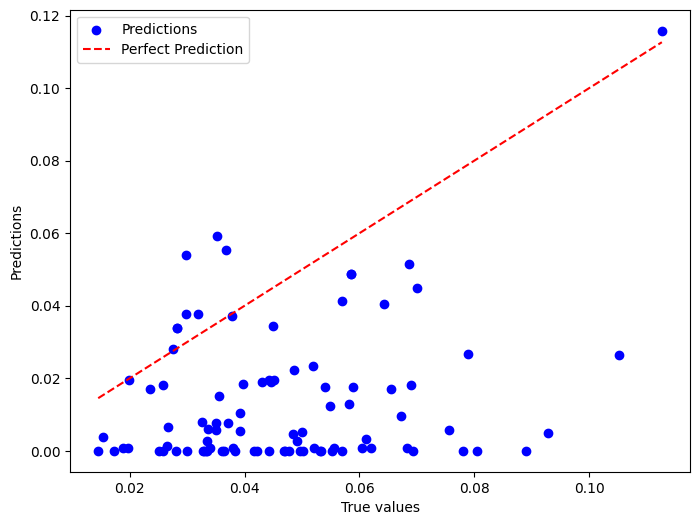

RMSE: 0.04036853317773891
R2: -3.373095939394215
CORRELATION: 0.2530932386830538


In [532]:
fynesse.assess.plot_predictions_against_trues(trues, preds)

### Predicting share of migrants in the area

Now let's try to predict the additional census variable we selected in the previous step.

In [534]:
def get_true_MI_AddrYearAgoOutUK_Norm(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: True share of migrants that used to live outside of the UK one year ago in that area (value between 0 and 1).
    """

    oa = oa_by_coordinates(latitude, longitude)

    if oa is None:
        return None
    else:
        query = f"""
        SELECT MI_AddrYearAgoOutUK_Norm
        FROM census_data_1
        WHERE geography_code = '{oa}';
        """
        true_value = fynesse.assess.execute_query(conn, query)[0][0]

        return float(true_value)

In [542]:
def estimate_MI_AddrYearAgoOutUK_Norm(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: Estimated share of migrants that used to live outside of the UK one year ago in that area (value between 0 and 1).
    """
    
    selected_features = ['amenity', 'tourism', 'leisure', 'cuisine', 'sport', 'shop', 'religion', 'house', 'building', 'emergency', 'historic', 'power', 'military']
    
    x = census_data_1_df[selected_features].to_numpy()
    y = census_data_1_df['MI_AddrYearAgoOutUK_Norm'].to_numpy()
    model = sm.OLS(y, x)
    results = model.fit()

    oa = oa_by_coordinates(latitude, longitude)
    
    if oa is None:
        return None
    else:
        x_pred = census_data_1_df[census_data_1_df['geography_code'] == oa][selected_features].to_numpy()
        y_pred = results.get_prediction(x_pred).summary_frame(alpha=0.00)['mean']
        return y_pred[0]

In [547]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

lat_min, lat_max = 51.3, 53.8
lon_min, lon_max = -2.5, 1.5
samples = 100
    
coords = [(random.uniform(lat_min, lat_max), random.uniform(lon_min, lon_max)) for _ in range(samples)]
trues = []
preds = []

for i in range(samples):
    
    latitude = coords[i][0]
    longitude = coords[i][1]
    oa = oa_by_coordinates(latitude, longitude)
    true_value = get_true_MI_AddrYearAgoOutUK_Norm(latitude, longitude)

    if oa is not None:
        pred_value = estimate_MI_AddrYearAgoOutUK_Norm(latitude, longitude)
        trues.append(true_value)
        preds.append(pred_value)

print(f"Correlation coefficient: {np.corrcoef(trues, preds)[0, 1]}")

Correlation coefficient: 0.4518782367671427


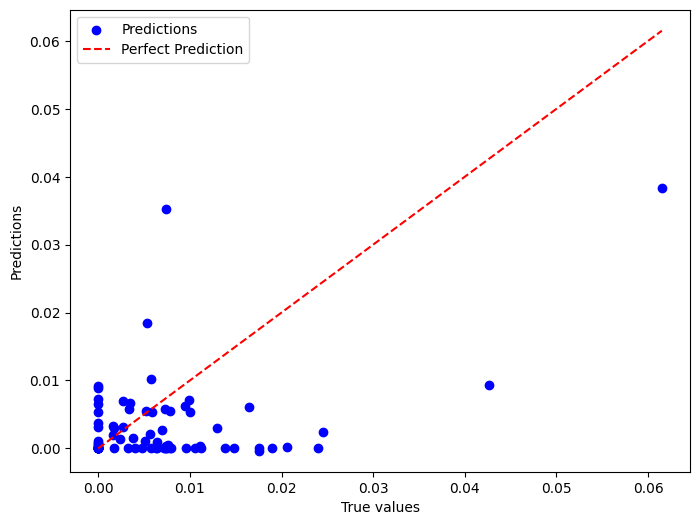

RMSE: 0.009222659678923118
R2: 0.027933032480942366
CORRELATION: 0.4518782367671427


In [548]:
fynesse.assess.plot_predictions_against_trues(trues, preds)

## Discussion

### Story and structure

Marks awarded for inline explanation and structure, no need for answers here.

### Design decisions

One of the toughest design decisions I had to face during this project was to decide how to store geometrical data. While it's possible to do simple operations (such as computing area of polygon) in SQL, for more complex operations I needed to use dataframes. Limited time for this task puts further constraints on this topic.

### Comparison

Not sure what to put here - to be discussed.

### Reusability

Quite a big number of snippets of code produced during this project can be effectively reused. Most of such pieces of code has been placed into fynesse library, some of them still remain in the code.

# Task 2: miniproject (13 marks)

We expect your miniproject to be more advanced than the example project, and that's why we allocated more marks to it. The first 7 marks will be allocated similarly to Task 1.

6 remaining points are *bonus* - they will be allocated for going far beyond what you did in Task 1, either in data access, assess, address or story.

#### Choosing your topic

You are given a lot of flexibility in choosing a miniproject topic.

Some hints:
- Your project should be based on the Census, Price Paid, OSM and Election datasets.
- It's a good idea to pick something that you are interested in.
- Bear in mind there are no marks dedicated to your overall prediction accuracy, so there is no advantage to picking 'easy' topics. It is perfectly ok to not reach significant predictive power, as long as you followed the proper process.

Some guidelines:
- Do not make a miniproject that furthers discriminatory rhetoric. In general, avoid topics that could be insensitive. If in doubt, message Radzim Sendyka (and *cc* Christian Cabrera) to discuss if this applies to your idea.
- Please avoid any projects that would require approval from the ethics comittee.
- Pick the scope of your projects that will allow you to show your skills. Some projects might not be challenging enough while others might be hard to make any progress in. Don't be scared to report negative results.

Please email Radzim Sendyka (and *cc* Christian Cabrera) with your project idea when you begin working on it, so we can let you know about any potential concerns (eg. potentially insensive, too off-topic, too simple, too complex) as soon as we can. You can change the topic up to the submission deadline, but let us know again in cases of major changes.

Most of the advice from Task 1 still applies, particularly around using an online relational database, structuring your notebook, fynesse, access-assess-address, data readiness levels, hints.

Sources you may want to include in your data include:

  - UK Census Data
    - UK Census 2021 data [here](https://www.ons.gov.uk/search?topics=9731,6646,3845,9497,4262,4128,7755,4994,6885,9724,7367&filter=datasets) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk).
    - Historical Census data [here](https://www.ons.gov.uk/census/historiccensusdata).
    - Geographic coordinates of Census Output Areas [here](https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2).
  - Spatial data
    - You should already have a connection to OpenStreetMaps.
    - You might want to also download the entire map for England (or more) [here](https://download.openstreetmap.fr/extracts/) or [here](https://wiki.openstreetmap.org/wiki/Planet.osm).
  - Election data
    - Recent Election Results data [here](https://commonslibrary.parliament.uk/research-briefings/cbp-10009/)
    - Historical Election Results data [here](https://commonslibrary.parliament.uk/research-briefings/cbp-8647/#fullreport).
    - Lookup reference between Output Areas and Parliamentary Constituencies [here](https://geoportal.statistics.gov.uk/datasets/5968b5b2c0f14dd29ba277beaae6dec3_0/explore).
  - Price Paid Data
    - You should have this data already in your database.
  - OSM
    - You should know how to access this data from previous practicals.

Example ideas:

- Are areas correlated in terms of census results? If so, find the areas that are leading change, and the ones that are following.
- Which historical census variables used to predict election results in the past, but don't seem related anymore?
- Census results are only updated once a decade, but new roads and houses are built every year. Can census results, for example those relating to travel, be predicted from basic map information, such as street networks?
- Building new houses is our best way of tackling the housing crisis. Use the information on new builds in the house prices dataset to explore what factors drive new developments, and make predictions for where the next houses will be built.
- House styles differ a lot between regions and inhabitants. Can you make any predictions about the house or area simply from looking at it's geometric shape and orientation?

Note that the ideas are just a starting point question. You should include more in-depth investigations into the data, validate your findings where applicable, and prepare visualisations.

## Title

### How often do unexpected cultural or political shifts lead to unpredictable electoral outcomes? 

## Description

The aim of the project is to investigate how often unexpected factors like region-specific cultural issues influence voting results.

TODO: expand this

## Project plan

- Extract relevant demographic features from census data.
- Add special indices to enrich the dataset.
- Cluster regions based on similarity of demographic profiles.
- Compare clusters to voting patterns.
- Identify demographic profiles strongly associated with specific voting patterns.
- Identify areas with anomalies in voting results (do a thorough analysis in assess).
- Build a model to predict voting results based on census data. 
- Analyse feature importance to identify links between demographic features and voting outcomes. 
- Identify regions where predictions deviate significantly from actual results (make use of LOOCV or something similar to avoid testing on region you used as part of your training, as it might not deviate much in this case).

## Imports

In [1156]:
import time
import seaborn as sns
from collections import Counter
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, classification_report, accuracy_score, confusion_matrix

## TOREMOVE - Functions

In [1303]:
# ACCESS

def print_columns(file_path):

    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        first_row = next(reader)
    
    for i, column_title in enumerate(first_row):
        print(f"Column {i}: {column_title}")

def count_columns(file_path):

    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        first_row = next(reader)
        column_count = len(first_row)

    return column_count

def add_census_feature(table, code, column, name, dir = '.'):
    
    fynesse.access.download_census_data(code, dir)
    file_path = f'{dir}/census2021-{code.lower()}/census2021-{code.lower()}-oa.csv'
    census_data_df = pd.read_csv(file_path)
    title = census_data_df.columns[column]
    print(f"Original title: {title}")

    # user_input = input("Do you want to proceed with adding this feature? (Press Enter to continue or 'q' to quit): ")
    # if user_input.lower() == 'q':
    #     print("Operation cancelled by the user.")
    #     return

    query = """
    CREATE TABLE IF NOT EXISTS `temp` (
      `date` int unsigned NOT NULL,
      `geography` varchar(9) COLLATE utf8_bin NOT NULL,
      `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
    """

    for i in range(3, count_columns(file_path)):
        query += f'  `{i}` int unsigned NOT NULL,'

    query += """
      `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
      PRIMARY KEY (`db_id`)
    ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

    fynesse.assess.execute_query(conn, query)

    fynesse.access.csv_to_db(conn, file_path, 'temp', ignore_first_row=True)

    fynesse.assess.create_single_index(conn, 'idx_geography_code', 'temp', 'geography_code')

    column_name = f'{code}_{column}_{name}'

    query = f"ALTER TABLE {table} ADD COLUMN {column_name} int unsigned NOT NULL DEFAULT 0;"

    fynesse.assess.execute_query(conn, query)
        
    query = f"""
    UPDATE {table}
    SET {column_name} = (
        SELECT temp.{column}
        FROM temp
        WHERE {table}.OA21CD = temp.geography_code
    );
    """

    fynesse.assess.execute_query(conn, query)

    fynesse.assess.execute_query(conn, "DROP TABLE temp;")

    print(f"Column {column_name} has been added to the table {table} successfully.")

In [1304]:
# ASSESS

def add_geography_and_oa_to_pp_data(year, month):
    
    x = f"{year}-{month:02}-01"
    y = f"{year}-{month:02}-31"

    query = f"""
    UPDATE pp_data_with_geography 
    JOIN postcode_data
    ON pp_data_with_geography.postcode = postcode_data.postcode
    SET 
        pp_data_with_geography.easting = postcode_data.easting,
        pp_data_with_geography.northing = postcode_data.northing,
        pp_data_with_geography.geography = ST_GeomFromText(CONCAT('POINT(', postcode_data.easting, ' ', postcode_data.northing, ')'))
    WHERE pp_data_with_geography.date_of_transfer >= '{x}' AND pp_data_with_geography.date_of_transfer <= '{y}';
    """
    
    start = time.time()
    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE pp_data_with_geography
    JOIN oa_data
    ON ST_Within(pp_data_with_geography.geography, oa_data.geometry)
    SET pp_data_with_geography.OA21CD = oa_data.OA21CD
    WHERE pp_data_with_geography.date_of_transfer >= '{x}' 
    AND pp_data_with_geography.date_of_transfer <= '{y}';
    """
    
    fynesse.assess.execute_query(conn, query)
    end = time.time()
    
    print(f"Transactions from {x} to {y} have been processed in {end - start} seconds.")

def get_summary_on_table(conn, table_name):

    table_status = fynesse.assess.execute_query(conn, f"SHOW TABLE STATUS LIKE '{table_name}';")
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print(f"\nTable {table_name} - Approx Row Count {approx_row_count//100000/10}M")

    column_names = fynesse.assess.execute_query(conn, f"SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{table_name}';")
    print(tuple(item[0] for item in column_names))

    limit = 3
    first_rows = fynesse.assess.execute_query(conn, f"SELECT * FROM `{table_name}` LIMIT {limit};")
    for row in first_rows:
        print(row)

    indices = fynesse.assess.execute_query(conn, f"SHOW INDEX FROM `{table_name}`;")
    if indices:
        print("Indices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("No indices set on this table.")

def db_to_df(table_name, columns, sort_by_column):
    
    query = f"SELECT {', '.join(columns)} FROM {table_name} ORDER BY {sort_by_column} ASC"
    r = fynesse.assess.execute_query(conn, query)
    df = pd.DataFrame(r, columns=columns)

    return df

def plot_correlation_between_dataframes(df1, df2):
    
    correlation_matrix_full = np.zeros((df1.shape[1], df2.shape[1]))
    
    for i, col1 in enumerate(df1.columns):
        for j, col2 in enumerate(df2.columns):
            correlation_matrix_full[i, j] = df1[col1].corr(df2[col2])
    
    correlation_matrix_df = pd.DataFrame(correlation_matrix_full, index=df1.columns, columns=df2.columns)
    # correlation_matrix_df = correlation_matrix_df.applymap(lambda x: np.nan if -0.10 < x < 0.10 else x)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(correlation_matrix_df, annot=True, fmt='.2f', cmap='coolwarm', 
                cbar_kws={'label': 'Correlation'}, ax=ax, linewidths=0.5, linecolor='black', 
                annot_kws={'size': 10, 'weight': 'bold'})

    ax.set_xticklabels(correlation_matrix_df.columns, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(np.arange(len(correlation_matrix_df.index)))
    ax.set_yticklabels(correlation_matrix_df.index, rotation=0, fontsize=10)
        
    # ax.set_xticklabels(correlation_matrix_df.columns, rotation=45, ha='right', fontsize=10)
    # ax.set_yticklabels(correlation_matrix_df.index, rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_cluster_matrix(matrix, xlabel, ylabel):

    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='coolwarm', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Count')
    plt.title("Cluster Grid (Counts)")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(len(matrix.columns)), matrix.columns)
    plt.yticks(range(len(matrix.index)), matrix.index)
    
    for i in range(len(matrix.index)):
        for j in range(len(matrix.columns)):
            plt.text(j, i, f"{matrix.iloc[i, j]}", ha='center', va='center', color="black")

    plt.tight_layout()
    plt.show()

def elbow_method(data, max_k=10):
    distortions = []
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.title("Elbow Method (Distortion)")
    plt.xlabel("Number of clusters")
    plt.ylabel("Distortion")

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title("Silhouette Score")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    
    plt.tight_layout()
    plt.show()

def print_counts_per_region(table, column):
    
    n_rows = fynesse.assess.execute_query(conn, f"SELECT COUNT(*) AS row_count FROM {table};")[0][0]
    print(f"Total: {n_rows}")

    for letter in ['E', 'W', 'S', 'N']:
        
        n_rows = fynesse.assess.execute_query(conn, f"SELECT COUNT(*) AS row_count FROM {table} WHERE {column} LIKE '{letter}%';")[0][0]
        print(f"{letter}: {n_rows}")

def add_feature_from_oa_to_pc_data(original_table, feature):
    
    query = f"""
    ALTER TABLE pc_data
    ADD COLUMN {feature} bigint DEFAULT 0 NOT NULL;
    """
    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE pc_data
    JOIN (
        SELECT
            oa_to_pc.PCON25CD,
            SUM({original_table}.{feature}) AS {feature}
        FROM
            oa_to_pc
        JOIN
            {original_table} ON oa_to_pc.OA21CD = {original_table}.OA21CD
        GROUP BY
            oa_to_pc.PCON25CD
    ) AS temp
    ON pc_data.ONS_ID = temp.PCON25CD
    SET pc_data.{feature} = temp.{feature};
    """
    fynesse.assess.execute_query(conn, query)

    print(f"Feature {feature} has been added to pc_data successfully.")

def get_ew_boundary_polygon():
    
    uk_boundary_coords = [
        (-5.75, 50.00),
        (-4.45, 51.10),
        (-3.10, 51.25),
        (-2.75, 51.55),
        (-3.35, 51.35),
        (-5.35, 51.75),
        (-4.15, 52.60),
        (-4.60, 53.40),
        (-3.15, 53.50),
        (-3.75, 54.60),
        (-2.00, 55.80),
        (-1.60, 55.60),
        (-1.15, 54.65),
        (-0.50, 54.50),
        (0.20, 53.60),
        (0.45, 53.00),
        (1.30, 53.00),
        (1.80, 52.60),
        (1.60, 52.00),
        (0.80, 51.50),
        (1.70, 51.40),
        (0.35, 50.50),
        (-3.25, 50.60),
        (-3.70, 50.20),
        (-4.70, 50.30),
        (-5.15, 50.00),
        (-5.75, 50.00)
    ]

    return uk_boundary_coords

In [1308]:
# ADDRESS

def cross_validation(x, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    r2_list = []
    rmse_list = []
    corr_list = []

    for train_index, test_index in kf.split(x):
        # using iloc[] to correctly index the rows
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = sm.OLS(y_train, x_train)
        results = model.fit()
        y_pred = results.get_prediction(x_test).summary_frame(alpha=0.00)['mean']
        
        r2_list.append(r2_score(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        corr_list.append(np.corrcoef(y_test, y_pred)[0, 1])

    mean_r2 = np.mean(r2_list)
    mean_rmse = np.mean(rmse_list)
    mean_corr = np.mean(corr_list)

    print(f"Mean R2: {mean_r2}")
    print(f"Mean RMSE: {mean_rmse}")
    print(f"Mean Correlation: {mean_corr}")

## Access

In [678]:
conn = fynesse.access.create_connection()

Connection established!


### General election data

In [ ]:
url = "https://researchbriefings.files.parliament.uk/documents/CBP-10009/HoC-GE2024-results-by-constituency.csv"
file_name = "dataForPart2/GE2024_results.csv"
fynesse.access.download_data_csv([url], [file_name])

In [609]:
query_create_ge_2024_results = """
CREATE TABLE IF NOT EXISTS `ge_2024_results` (
  `ONS_ID` varchar(9) COLLATE utf8_bin NOT NULL,
  `ONS_region_ID` varchar(9) COLLATE utf8_bin NOT NULL,
  `Constituency_name` tinytext COLLATE utf8_bin NOT NULL,
  `County_name` tinytext COLLATE utf8_bin NOT NULL,
  `Region_name` tinytext COLLATE utf8_bin NOT NULL,
  `Country_name` tinytext COLLATE utf8_bin NOT NULL,
  `Constituency_type` tinytext COLLATE utf8_bin NOT NULL,
  `Declaration_time` tinytext COLLATE utf8_bin NOT NULL,
  `Member_first_name` tinytext COLLATE utf8_bin NOT NULL,
  `Member_surname` tinytext COLLATE utf8_bin NOT NULL,
  `Member_gender` tinytext COLLATE utf8_bin NOT NULL,
  `Result` tinytext COLLATE utf8_bin NOT NULL,
  `First_party` tinytext COLLATE utf8_bin NOT NULL,
  `Second_party` tinytext COLLATE utf8_bin NOT NULL,
  `Electorate` int unsigned NOT NULL,
  `Valid_votes` int unsigned NOT NULL,
  `Invalid_votes` int unsigned NOT NULL,
  `Majority` int unsigned NOT NULL,
  `Con` int unsigned NOT NULL,
  `Lab` int unsigned NOT NULL,
  `LD` int unsigned NOT NULL,
  `RUK` int unsigned NOT NULL,
  `Green` int unsigned NOT NULL,
  `SNP` int unsigned NOT NULL,
  `PC` int unsigned NOT NULL,
  `DUP` int unsigned NOT NULL,
  `SF` int unsigned NOT NULL,
  `SDLP` int unsigned NOT NULL,
  `UUP` int unsigned NOT NULL,
  `APNI` int unsigned NOT NULL,
  `All_other_candidates` int unsigned NOT NULL,
  `Of_which_other_winner` int unsigned NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_ge_2024_results)

fynesse.access.csv_to_db(conn, 'dataForPart2/GE2024_results.csv', 'ge_2024_results', ignore_first_row=True)

Loading data into the table
Data loaded into the table ge_2024_results


In [615]:
fynesse.assess.create_single_index(conn, 'idx_ons_id', 'ge_2024_results', 'ONS_ID')
fynesse.assess.create_single_index(conn, 'idx_ons_region_id', 'ge_2024_results', 'ONS_region_ID')
fynesse.assess.create_single_index(conn, 'idx_result', 'ge_2024_results', 'Result')
fynesse.assess.create_single_index(conn, 'idx_first_party', 'ge_2024_results', 'First_party')
fynesse.assess.create_single_index(conn, 'idx_second_party', 'ge_2024_results', 'Second_party')

[]

### OA to PC lookup data

In [613]:
query_create_oa_to_pc = """
CREATE TABLE IF NOT EXISTS `oa_to_pc` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `PCON25CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `PCON25NM` tinytext COLLATE utf8_bin NOT NULL,
  `PCON25NMW` tinytext COLLATE utf8_bin NOT NULL,
  `LAD21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LAD21NM` tinytext COLLATE utf8_bin NOT NULL,
  `ObjectId` int unsigned NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_oa_to_pc)

fynesse.access.csv_to_db(conn, 'dataForPart2/Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.csv', 'oa_to_pc', ignore_first_row=True)

Loading data into the table
Data loaded into the table oa_to_pc


In [617]:
fynesse.assess.create_single_index(conn, 'idx_oa21cd', 'oa_to_pc', 'OA21CD')
fynesse.assess.create_single_index(conn, 'idx_pcon25cd', 'oa_to_pc', 'PCON25CD')
fynesse.assess.create_single_index(conn, 'idx_lad21cd', 'oa_to_pc', 'LAD21CD')

[]

### Census and OSM data

In [758]:
query = """
CREATE TABLE osm_and_census_data_2 AS
SELECT 
    date, geography_code AS OA21CD, db_id, 
    amenity, tourism, leisure, cuisine, emergency, historic, sport, shop, religion, power, military, house, building
FROM census_data_1;
"""
fynesse.assess.execute_query(conn, query)

fynesse.assess.execute_query(conn, "ALTER TABLE osm_and_census_data_2 ADD PRIMARY KEY (OA21CD);")

[]

In [787]:
code_column_name = [
    ('TS007A', 8, 'Age_20_24'), 
    ('TS007A', 11, 'Age_35_39'), 
    ('TS007A', 14, 'Age_50_54'), 
    ('TS007A', 17, 'Age_65_69'),
    ('TS021', 4, 'Ethnic_Asian'),
    ('TS021', 10, 'Ethnic_Black'),
    ('TS021', 19, 'Ethnic_White'),
    ('TS054', 4, 'Tenure_Own'), 
    ('TS054', 7, 'Tenure_ShareOwn'), 
    ('TS054', 9, 'Tenure_SocRent'), 
    ('TS054', 12, 'Tenure_PrivRent'),
    ('TS066', 4, 'Economic_Act'), 
    ('TS066', 16, 'Economic_ActStudent'), 
    ('TS066', 28, 'Economic_Inact'),
    ('TS067', 4, 'Qualification_No'), 
    ('TS067', 5, 'Qualification_L1'), 
    ('TS067', 6, 'Qualification_L2'),
    ('TS004', 4, 'Birth_Europe'), 
    ('TS004', 5, 'Birth_UK'), 
    ('TS004', 13, 'Birth_Africa'), 
    ('TS004', 14, 'Birth_MEandAsia'),
    ('TS037', 4, 'Health_VeryGood'), 
    ('TS037', 6, 'Health_Fair'), 
    ('TS037', 8, 'Health_VeryBad')
]

In [ ]:
codes = list(set(triple[0] for triple in code_column_name))
codes.sort()

for code in codes:
    file_path = f'dataForPart2/census2021-{code.lower()}/census2021-{code.lower()}-oa.csv'
    print(f"Code: {code}")
    print_columns(file_path)
    print()

In [798]:
for element in code_column_name:
    code, column, name = element
    add_census_feature('osm_and_census_data_2', code, column, name, 'dataForPart2')

Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 20 to 24 years
Loading data into the table
Data loaded into the table temp
Column TS007A_8_Age_20_24 has been added to the table osm_and_census_data_2 successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 35 to 39 years
Loading data into the table
Data loaded into the table temp
Column TS007A_11_Age_35_39 has been added to the table osm_and_census_data_2 successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 50 to 54 years
Loading data into the table
Data loaded into the table temp
Column TS007A_14_Age_50_54 has been added to the table osm_and_census_data_2 successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 65 to 69 years
Loading data into the table
Data loaded into the table temp
Column TS007A_17_Age_65_69 has been added to the table osm_and_census_data_2 successfully.
Files alr

In [799]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'osm_and_census_data_2', 'OA21CD')

[]

### Summary on access

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'NSSEC_L15_Norm', 'MI_AddrYearAgoOutUK_Norm')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_to_pc - Approx Row Count 0.1M
('OA21CD', 'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM', 'ObjectId', 'db_id')
('E00000337', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 1, 1)
('E00000338', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 2, 2)
('E00000340', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 3, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_oa21cd (BTREE): Column OA21CD
 - idx_pcon25cd (BTREE): Column PCON25CD
 - idx_lad21cd (BTREE): Column LAD21CD

Table osm_and_census_data_2 - Approx Row Count 0.1M
('date', 'OA21CD', 'db_id', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad')
(2021, 'E00000001', 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 15, 24, 5, 3, 155, 72, 0, 7, 15, 98, 0, 63, 4, 7, 10, 149, 118, 0, 6, 98, 26, 0)
(2021, 'E00000003', 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 13, 20, 35, 24, 5, 209, 91, 0, 2, 17, 139, 1, 83, 5, 3, 8, 207, 184, 7, 18, 146, 15, 2)
(2021, 'E00000005', 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 5, 8, 12, 13, 0, 85, 40, 0, 2, 21, 68, 1, 36, 3, 2, 3, 88, 73, 2, 11, 62, 8, 0)
Indices:
 - PRIMARY (BTREE): Column OA21CD
 - idx_oa (BTREE): Column OA21CD

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@', 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@', 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@', 'E00182758')
Indices:
 - geometry (SPATIAL): Column geometry
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - idx_oa (BTREE): Column OA21CD

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

## Assess

In [1257]:
conn = fynesse.access.create_connection()

Connection established!


### Filtering and preparing the data

In [ ]:
"""

Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_to_pc - Approx Row Count 0.1M
('OA21CD', 'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM', 'ObjectId', 'db_id')
('E00000337', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 1, 1)
('E00000338', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 2, 2)
('E00000340', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 3, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_oa21cd (BTREE): Column OA21CD
 - idx_pcon25cd (BTREE): Column PCON25CD
 - idx_lad21cd (BTREE): Column LAD21CD

Table osm_and_census_data_2 - Approx Row Count 0.1M
('date', 'OA21CD', 'db_id', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad')
(2021, 'E00000001', 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 15, 24, 5, 3, 155, 72, 0, 7, 15, 98, 0, 63, 4, 7, 10, 149, 118, 0, 6, 98, 26, 0)
(2021, 'E00000003', 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 13, 20, 35, 24, 5, 209, 91, 0, 2, 17, 139, 1, 83, 5, 3, 8, 207, 184, 7, 18, 146, 15, 2)
(2021, 'E00000005', 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 5, 8, 12, 13, 0, 85, 40, 0, 2, 21, 68, 1, 36, 3, 2, 3, 88, 73, 2, 11, 62, 8, 0)
Indices:
 - PRIMARY (BTREE): Column OA21CD
 - idx_oa (BTREE): Column OA21CD
"""

In [739]:
print_counts_per_region('ge_2024_results', 'ONS_ID')

Total: 650
E: 543
W: 32
S: 57
N: 18


In [741]:
fynesse.assess.execute_query(conn, "DELETE FROM ge_2024_results WHERE ONS_ID LIKE 'N%' OR ONS_ID LIKE 'S%';")

[]

In [742]:
print_counts_per_region('ge_2024_results', 'ONS_ID')

Total: 575
E: 543
W: 32
S: 0
N: 0


In [750]:
query = """
CREATE TABLE pc_data AS
SELECT
    ge_2024_results.ONS_ID,
    CAST(AVG(oa_data.BNG_E) AS FLOAT) AS BNG_E,
    CAST(AVG(oa_data.BNG_N) AS FLOAT) AS BNG_N,
    AVG(oa_data.LAT) AS LAT,
    AVG(oa_data.LON) AS LON,
    SUM(oa_data.ShapeArea) AS AREA
FROM
    ge_2024_results
JOIN
    oa_to_pc ON ge_2024_results.ONS_ID = oa_to_pc.PCON25CD
JOIN
    oa_data ON oa_to_pc.OA21CD = oa_data.OA21CD
GROUP BY
    ge_2024_results.ONS_ID;
"""
fynesse.assess.execute_query(conn, query)

fynesse.assess.execute_query(conn, "ALTER TABLE pc_data ADD PRIMARY KEY (ONS_ID);")

[]

In [817]:
features_to_add = list(fynesse.assess.execute_query(conn, "SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'osm_and_census_data_2';"))
features_to_add = [el[0] for el in features_to_add]
features_to_add = features_to_add[3:]

for feature in features_to_add:
    add_feature_from_oa_to_pc_data('osm_and_census_data_2', feature)

### Adding prices paid data to form new features of parliamentary constituencies

In [1059]:
query = """
CREATE TABLE pp_data_with_geography
SELECT * FROM pp_data 
WHERE date_of_transfer >= '2022-08-01';
"""
fynesse.assess.execute_query(conn, query)

query = """
ALTER TABLE pp_data_with_geography 
ADD COLUMN easting FLOAT, 
ADD COLUMN northing FLOAT,
ADD COLUMN geography POINT
ADD COLUMN OA21CD varchar(9);;
"""
fynesse.assess.execute_query(conn, query)

fynesse.assess.create_single_index(conn, 'idx_db_id', 'pp_data_with_geography', 'db_id')
fynesse.assess.create_single_index(conn, 'idx_postcode', 'pp_data_with_geography', 'postcode')
fynesse.assess.create_single_index(conn, 'idx_date_of_transfer', 'pp_data_with_geography', 'date_of_transfer')

[]

In [ ]:
year = 2024
month = 9

for _ in range(26):

    add_geography_and_oa_to_pp_data(year, month)
    
    if month == 1:
        year -= 1
        month = 12
    else:
        month -= 1

In [1174]:
fynesse.assess.execute_query(conn, "SELECT COUNT(*) FROM pp_data_with_geography;")[0][0]

1612832

In [1229]:
fynesse.assess.execute_query(conn, "DELETE FROM pp_data_with_geography WHERE OA21CD IS NULL;")

[]

In [1233]:
fynesse.assess.execute_query(conn, "SELECT COUNT(*) FROM pp_data_with_geography;")[0][0]

1605461

In [1234]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'pp_data_with_geography', 'OA21CD')

[]

In [1235]:
get_summary_on_table(conn, 'pp_data_with_geography')


Table pp_data_with_geography - Approx Row Count 1.5M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id', 'easting', 'northing', 'geography', 'OA21CD')
('{E7B085FC-4E71-7E31-E053-6C04A8C0E67F}', 590000, datetime.date(2022, 8, 12), 'ME18 5AQ', 'D', 'N', 'F', 'HAVENFIELD', '', 'THE STREET', 'TESTON', 'MAIDSTONE', 'MAIDSTONE', 'KENT', 'A', 'A', 29360121, 570449.0, 153417.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\xa2h!A\x00\x00\x00\x00H\xba\x02A', 'E00123488')
('{E7B085FC-4E77-7E31-E053-6C04A8C0E67F}', 485000, datetime.date(2022, 8, 10), 'DA16 1RH', 'S', 'N', 'F', '48', '', 'CHARMOUTH ROAD', '', 'WELLING', 'BEXLEY', 'GREATER LONDON', 'A', 'A', 29360137, 547084.0, 176725.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x1

In [ ]:
fynesse.assess.execute_query(conn, f"SELECT DISTINCT property_type FROM pp_data_with_geography;")
fynesse.assess.execute_query(conn, f"SELECT DISTINCT new_build_flag FROM pp_data_with_geography;")
fynesse.assess.execute_query(conn, f"SELECT DISTINCT tenure_type FROM pp_data_with_geography;")

In [ ]:
"""
property_type - the type of property sold.
- T - Terraced - A house that shares walls with houses on both sides.  
- D - Detached - A standalone house with no shared walls.  
- F - Flat/Maisonette - A flat (apartment) or maisonette, typically in a shared building.  
- S - Semi-Detached - A house that shares a wall with one neighboring property.  
- O - Other - Any property type that does not fit into the above categories.

new_build_flag - whether the house being sold is newly built or not.
- N - No
- Y - Yes

tenure_type - the legal ownership arrangement of the property.
- F - Freehold - The buyer owns the property and the land it stands on indefinitely.  
- L - Leasehold - The buyer owns the property for a specific period (e.g., 99 or 125 years) but not the land it stands on. Ownership reverts to the freeholder when the lease expires.
"""

In [1259]:
query = f"""
CREATE TABLE pp_data_per_oa (
    OA21CD VARCHAR(9) PRIMARY KEY,
    houses_sum_of_prices FLOAT DEFAULT 0,
    houses_total_number INT DEFAULT 0,
    houses_terraced INT DEFAULT 0,
    houses_detached INT DEFAULT 0,
    houses_flat INT DEFAULT 0,
    houses_semidetached INT DEFAULT 0,
    houses_other INT DEFAULT 0,
    houses_old INT DEFAULT 0,
    houses_new INT DEFAULT 0,
    houses_freehold INT DEFAULT 0,
    houses_leasehold INT DEFAULT 0
);
"""
fynesse.assess.execute_query(conn, query)

[]

In [1261]:
query = f"""
INSERT INTO pp_data_per_oa (
    OA21CD,
    houses_sum_of_prices,
    houses_total_number,
    houses_terraced,
    houses_detached,
    houses_flat,
    houses_semidetached,
    houses_other,
    houses_old,
    houses_new,
    houses_freehold,
    houses_leasehold
)
SELECT 
    OA21CD,
    SUM(price) AS houses_sum_of_prices,
    COUNT(*) AS houses_total_number,
    COUNT(CASE WHEN property_type = 'T' THEN 1 END) AS houses_terraced,
    COUNT(CASE WHEN property_type = 'D' THEN 1 END) AS houses_detached,
    COUNT(CASE WHEN property_type = 'F' THEN 1 END) AS houses_flat,
    COUNT(CASE WHEN property_type = 'S' THEN 1 END) AS houses_semidetached,
    COUNT(CASE WHEN property_type = 'O' THEN 1 END) AS houses_other,
    COUNT(CASE WHEN new_build_flag = 'N' THEN 1 END) AS houses_old,
    COUNT(CASE WHEN new_build_flag = 'Y' THEN 1 END) AS houses_new,
    COUNT(CASE WHEN tenure_type = 'F' THEN 1 END) AS houses_freehold,
    COUNT(CASE WHEN tenure_type = 'L' THEN 1 END) AS houses_leasehold
FROM pp_data_with_geography
GROUP BY OA21CD;
"""
fynesse.assess.execute_query(conn, query)

[]

In [1267]:
get_summary_on_table(conn, 'pp_data_per_oa')


Table pp_data_per_oa - Approx Row Count 0.1M
('OA21CD', 'houses_sum_of_prices', 'houses_total_number', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_average_price')
('E00000001', 11770000.0, 7, 0, 0, 7, 0, 0, 7, 0, 0, 7, 1681430.0)
('E00000003', 19530100.0, 11, 2, 0, 9, 0, 0, 11, 0, 0, 11, 1775470.0)
('E00000005', 22325400.0, 23, 0, 0, 23, 0, 0, 23, 0, 0, 23, 970670.0)
Indices:
 - PRIMARY (BTREE): Column OA21CD


In [ ]:
features_to_add = list(fynesse.assess.execute_query(conn, "SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'pp_data_per_oa';"))
features_to_add = [el[0] for el in features_to_add]
features_to_add = features_to_add[1:]

for feature in features_to_add:
    add_feature_from_oa_to_pc_data('pp_data_per_oa', feature)

In [ ]:
query = f"""
ALTER TABLE pc_data
ADD COLUMN houses_average_price FLOAT;
"""
fynesse.assess.execute_query(conn, query)

query = f"""
UPDATE pc_data
SET houses_average_price = 
    CASE 
        WHEN houses_total_number = 0 THEN 0
        ELSE houses_sum_of_prices / houses_total_number
    END;
"""
fynesse.assess.execute_query(conn, query)

In [1280]:
get_summary_on_table(conn, 'pc_data')


Table pc_data - Approx Row Count 0.0M
('ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'ho

### TOCOMPLETE - Analysing the data per parliamentary constituencies

In [ ]:
get_summary_on_table(conn, 'pc_data')

In [ ]:
get_summary_on_table(conn, 'ge_2024_results')

In [ ]:
"""

Table pc_data - Approx Row Count 0.0M
('ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price')
('E14001063', 486019.0, 154644.0, 51.28444433858401, -0.7679580485594628, 56663490.720703125, 105, 5, 7, 41, 2, 0, 5, 134, 8, 0, 0, 2488, 4433, 6578, 8868, 8190, 4961, 15588, 2776, 93164, 29186, 799, 6957, 9222, 63367, 1733, 30563, 16909, 11352, 13753, 98776, 91404, 2603, 14448, 58348, 13623, 915, 793, 494, 798, 829, 104, 2767, 251, 2181, 837, 1269768176, 3018, 420732)
('E14001064', 404904.0, 301132.0, 52.60795950731694, -1.9290075487648415, 53757197.34863281, 76, 1, 1, 17, 0, 1, 3, 28, 10, 3, 0, 389, 5184, 4576, 5463, 6977, 4803, 8130, 1952, 79884, 29470, 220, 5250, 4210, 44266, 1157, 31547, 16897, 8201, 10965, 89496, 87678, 787, 2870, 41645, 13570, 1253, 488, 513, 329, 933, 62, 2324, 1, 1832, 493, 653306461, 2325, 280992)
('E14001065', 377431.0, 389086.0, 53.39812510788061, -2.340879815399267, 51612935.833496094, 19, 3, 1, 6, 0, 0, 3, 20, 7, 0, 0, 16, 179, 3925, 6963, 7225, 4806, 12185, 1658, 81296, 30216, 239, 4637, 5618, 48577, 1208, 29675, 9143, 5680, 9708, 90441, 86205, 1617, 7792, 56963, 10116, 886, 590, 541, 642, 934, 102, 2743, 66, 1809, 1000, 1620365202, 2809, 576848)
Indices:
 - PRIMARY (BTREE): Column ONS_ID

Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party

"""

In [1302]:
# add_census_feature('osm_and_census_data_2', code, column, name, 'dataForPart2')
# add_feature_from_oa_to_pc_data('osm_and_census_data_2', feature)

In [1283]:
fynesse.access.db_to_csv(conn, 'pc_data', "dataForPart2/pc_data.csv")
fynesse.access.db_to_csv(conn, 'ge_2024_results', "dataForPart2/ge_2024_results.csv")
pc_data = fynesse.access.csv_to_df("dataForPart2/pc_data.csv")
ge_2024_results = fynesse.access.csv_to_df("dataForPart2/ge_2024_results.csv")
merged_data = pd.merge(pc_data, ge_2024_results, on="ONS_ID")

Data successfully exported to dataForPart2/pc_data.csv
Data successfully exported to dataForPart2/ge_2024_results.csv


In [1310]:
labels_columns = ['ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA']
demographic_columns = [col for col in pc_data.columns if col not in labels_columns]
# voting_columns = ['Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'PC', 'All_other_candidates', 'Of_which_other_winner']
results_columns = ['Con', 'Lab', 'LD', 'RUK', 'Green', 'PC', 'All_other_candidates']

In [1311]:
print(demographic_columns)

['amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price']


In [1312]:
labels_df = pc_data[labels_columns]
demographic_data_df = pc_data[demographic_columns]
# voting_data_df = ge_2024_results[voting_columns]
results_data_df = ge_2024_results[results_columns]

In [ ]:
n_clusters = 5

# cluster = fynesse.assess.kmeans_clusters(demographic_data_df, n_clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(demographic_data_df)
demographic_clusters = kmeans.labels_

print("Demographics - Cluster sizes: ")
print(Counter(demographic_clusters))

print("Demographics - Census centroids: ")
print(kmeans.cluster_centers_)

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(demographic_data_df, demographic_clusters)
tree_rules = export_text(tree, feature_names=demographic_columns)

print("Demographics - Decision tree rules for clusters: ")
print(tree_rules)

# cluster = fynesse.assess.kmeans_clusters(results_data_df, n_clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(results_data_df)
results_clusters = kmeans.labels_

print("Results - Cluster sizes: ")
print(Counter(results_clusters))

print("Results - Census centroids: ")
print(kmeans.cluster_centers_)

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(results_data_df, results_clusters)
tree_rules = export_text(tree, feature_names=results_columns)

print("Results - Decision tree rules for clusters: ")
print()

plot_correlation_between_dataframes(demographic_data_df, results_data_df)

In [ ]:
df = labels_df.copy()
df['clustersDemo'] = demographic_clusters
df['clustersResu'] = results_clusters
grid = df.groupby(['clustersDemo', 'clustersResu']).size().reset_index(name='count').pivot_table(index='clustersDemo', columns='clustersResu', values='count', aggfunc='sum', fill_value=0)
plot_cluster_matrix(grid, "Results clusters", "Demographics clusters")

In [ ]:
uk_boundary_coords = get_ew_boundary_polygon()
uk_boundary_latitudes = [coord[1] for coord in uk_boundary_coords]
uk_boundary_longitudes = [coord[0] for coord in uk_boundary_coords]

fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

axes[0].plot(uk_boundary_longitudes, uk_boundary_latitudes, color='black', lw=2)
for cluster in range(n_clusters):
    subset = labels_df.loc[np.where(results_clusters == cluster)[0]]
    axes[0].scatter(subset['LON'], subset['LAT'], label=f'Cluster {cluster}', s=10)
axes[0].set_title('Result clusters')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()

axes[1].plot(uk_boundary_longitudes, uk_boundary_latitudes, color='black', lw=2)
for cluster in range(n_clusters):
    subset = labels_df.loc[np.where(demographic_clusters == cluster)[0]]
    axes[1].scatter(subset['LON'], subset['LAT'], label=f'Cluster {cluster}', s=10)
axes[1].set_title('Demographic clusters')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
for result in results_columns:
    x = demographic_data_df.copy()
    y = results_data_df[result].copy()
    print(f"Result for {result}")
    cross_validation(x, y, 5)

In [ ]:
# Scale the data
scaler = StandardScaler()
demographic_data_scaled = scaler.fit_transform(merged_data[demographic_columns])

# Applying KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_data['demographic_cluster'] = kmeans.fit_predict(demographic_data_scaled)

# Analysing clusters, using PCA to reduce the dimensionality to 2D for visualization
# TODO - change (add) visualisation type?
pca = PCA(n_components=2)
pca_components = pca.fit_transform(demographic_data_scaled)
merged_data['pca1'] = pca_components[:, 0]
merged_data['pca2'] = pca_components[:, 1]

# PCA loadings
loadings = pca.components_
loadings_df = pd.DataFrame(
    loadings.T,
    columns=['PC1', 'PC2'],
    index=demographic_columns
)
print(loadings_df)

# Plotting clusters in 2D space using PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='demographic_cluster', palette='Set2', data=merged_data, s=100, alpha=0.7)
plt.title("Clustered Regions Based on Demographics")
plt.show()

# Comparing clusters with voting patterns - group by clusters and calculate the average voting distribution
cluster_voting_pattern = merged_data.groupby('demographic_cluster')[results_columns].mean()
print(cluster_voting_pattern)

# Fine-tuning the clustering. Elbow Method, Silhouette Score, Davies-Bouldin index may be useful
elbow_method(demographic_data_scaled)

In [ ]:
# Selecting features (X) and target variable (Y)
X = merged_data[demographic_columns]
y = merged_data['Lab']

# Normalising the features
X_scaled = StandardScaler().fit_transform(X)

# Correlation analysis - calculating correlation between demographic features and voting outcomes
correlation_df = pd.DataFrame()
for col in results_columns:
    correlation_df[col] = merged_data[demographic_columns].corrwith(merged_data[col])
print("Correlation of demographic profiles with voting outcomes:")
print(correlation_df)

# Feature importance using random forest - training a Random Forest Classifier to predict the voting result
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': demographic_columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top Demographic Features Predicting Voting Patterns:")
print(feature_importances.head(10))

# Evaluating the model
y_pred = rf_model.predict(X_test)
print("Model Performance on Test Data:")
# print(classification_report(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))
print("Correlation: ", np.corrcoef(y_test, y_pred)[0][1])

In [ ]:
# Detecting anomalies in voting results
# predicting voting results based on demographic features
merged_data['Predicted_Result'] = rf_model.predict(X_scaled)

# comparing actual vs predicted results
merged_data['Anomaly_Score'] = np.abs(merged_data['Predicted_Result'] - merged_data['Lab'])

# using Z-scores to identify anomalies
merged_data['Anomaly_ZScore'] = zscore(merged_data['Anomaly_Score'])

# setting a threshold for anomalies (e.g., Z-score > 2 is an anomaly)
anomaly_threshold = 2
anomalies = merged_data[merged_data['Anomaly_ZScore'] > anomaly_threshold]

print("Detected Anomalous Areas in Voting Results:")
print(anomalies[['ONS_ID', 'Constituency_name', 'Lab', 'Predicted_Result', 'Anomaly_ZScore']])

# visualising the anomalies
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=merged_data['pca1'], y=merged_data['pca2'], hue=(merged_data['Anomaly_ZScore'] > anomaly_threshold),
    palette={True: 'red', False: 'blue'}, legend='full', alpha=0.7
)
plt.title("Visualization of Anomalies in Voting Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Anomaly", loc='upper right', labels=["Normal", "Anomaly"])
plt.show()

### Summary

In [ ]:
fynesse.assess.get_summary_on_db(conn)

## Address

In [ ]:
conn = fynesse.access.create_connection()

### TOCOMPLETE - Building a model to predict voting outcomes

In [1314]:
X = merged_data[demographic_columns]
y = merged_data['Lab']
X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Model Performance on Test Data:")
# print(classification_report(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))
print("Correlation: ", np.corrcoef(y_test, y_pred)[0][1])

Model Performance on Test Data:
Correlation:  0.2919891332668475


### Summary

In [ ]:
fynesse.assess.get_summary_on_db(conn)

## Discussion

## Conclusions

The below code is for marking purpuses only, and not part of your project. It helps us gather the data we need without asking you for database credentials, and scouring github pages. This is mandatory. If the code does not work for you, let us know immediately.

1) Please re-run the code from Practical 1 to help us see the contents of your database. We recommend you include all data sources there, but some smaller inputs are fine to use as files.

<div style="font-size: 12px;">

```python
tables = %sql SHOW TABLES;

for row in tables:
    table_name = row[0]
    print(f"\nTable: {table_name}")

    table_status = %sql SHOW TABLE STATUS LIKE '{table_name}';
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print("\nApprox Row Count:", approx_row_count//100000/10, "M")

    first_5_rows = %sql SELECT * FROM `{table_name}` LIMIT 5;
    print(first_5_rows)

    indices = %sql SHOW INDEX FROM `{table_name}`;
    if indices:
        print("\nIndices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("\nNo indices set on this table.")

Unfortunately I can't run the code above, so I'll display same output using different method.

In [233]:
import yaml
import pymysql

with open("credentials.yaml") as file:
    credentials = yaml.safe_load(file)

conn = pymysql.connect(
    user=credentials["username"],
    passwd=credentials["password"],
    host=credentials["url"],
    port=(int)(credentials["port"]),
    local_infile=1,
    db="ads_2024"
)

In [234]:
def ex_query(conn, query):
    
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()

    conn.commit()
    return rows

In [560]:
tables = ex_query(conn, f"SHOW TABLES;")

for row in tables:
    table_name = row[0]
    print(f"\nTable: {table_name}")

    table_status = ex_query(conn, f"SHOW TABLE STATUS LIKE '{table_name}';")
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print("\nApprox Row Count:", approx_row_count//100000/10, "M")

    first_5_rows = ex_query(conn, f"SELECT * FROM `{table_name}` LIMIT 5;")
    print(first_5_rows)

    indices = ex_query(conn, f"SHOW INDEX FROM `{table_name}`;")
    if indices:
        print("\nIndices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("\nNo indices set on this table.")


Table: census_data_1

Approx Row Count: 0.1 M
((2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428), (2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269), (2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115), (2021, 'E00000007', 'E00000007', 140, 62, 39, 5, 11, 3, 3, 1, 6, 10, 4, 146, 93, 5, 41, 7, 253, 29, 6, 79, 0, 6, 3, 45, 26, 1, 0, 8, 704, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 9, 0.071428571, 0.047945205), (2021, 'E00000010', 'E00000010', 170, 34, 45, 17, 27, 7, 10, 14, 11, 5, 5, 178, 153, 0, 19, 6, 181, 15, 6, 60, 0, 3, 3, 42, 11, 1, 0, 8, 

2) Please paste a link to your fynesse library below, and make sure it's publically accessible. Also run the code below, and make sure it worked, printing out the contents of your library.

In [236]:
fynesse_url = 'https://github.com/sdenyskov/sd995_ads_2024.git'

In [237]:
import fynesse
import os

print('FYNESSE STRUCTURE:')
package_path = os.path.dirname(fynesse.__file__)
for root, dirs, files in os.walk(package_path):
    level = root.replace(package_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

print('FILE CONTENTS')
for root, dirs, files in os.walk(package_path):
    for file in files:
        file_path = os.path.join(root, file)
        print(f"--- Contents of {file_path} ---\n")
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                print(f.read())
        except Exception as e:
            print(f"Could not read {file_path}: {e}")
        print("\n" + "-" * 50 + "\n")

FYNESSE STRUCTURE:
fynesse/
    defaults.yml
    address.py
    config.py
    access.py
    __init__.py
    assess.py
    __pycache__/
        address.cpython-310.pyc
        assess.cpython-310.pyc
        config.cpython-310.pyc
        access.cpython-310.pyc
        __init__.cpython-310.pyc
FILE CONTENTS
--- Contents of /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/defaults.yml ---

# Place config informatio you want everyone to have here.
data_url: https://raw.githubusercontent.com/lawrennd/datasets_mirror/main/


--------------------------------------------------

--- Contents of /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/address.py ---

from .config import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score



def fit_and_predict(x, y, x_pred, design_matrix = lambda x: x.reshape(-